In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shap
import sys
sys.path.append('./pyuid3')
#sys.path.append('./EXPLAN/LORE')
from lux.lux import LUX
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer
import random



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
import pickle
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import NearestNeighbors
import graphviz

from sklearn import tree
from sklearn.tree import  export_graphviz
from graphviz import Source
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from IPython.display import display
from IPython.display import SVG

from anchor import utils
from anchor import anchor_tabular
from pyuid3.data import Data
from pyuid3.entropy_evaluator import *
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches
from sklearn.preprocessing import normalize
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from pyuid3.data import Data
from pyuid3.uid3 import UId3
from sklearn.svm import SVC

import sys
sys.path.append('./EXPLAN')
import explan
from explan import DataGeneration,DataSelection,DataBalancing
from utils import *
from LORE import lore
from LORE.neighbor_generator import *
from neighbor_generator import *
from gpdatagenerator import calculate_feature_values

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [3]:
def prepare_ds(df, name = 'dataset', class_name='class', discrete=[], label_encoder={}):
    features = [f for f in df.columns if f not in [class_name]]
    
    dataset = {}
    dataset['name'] = name
    dataset['df'] = df
    dataset['columns'] = list(df.columns)
    dataset['class_name'] = class_name
    dataset['possible_outcomes'] = list(np.unique(df[class_name]))
    
    types = {}
    types['integer'] = [c for c,t in zip(df.columns, df.dtypes) if 'int' in str(t)]
    types['double'] = [c for c,t in zip(df.columns, df.dtypes) if 'float' in str(t)]
    types['string'] = [c for c,t in zip(df.columns, df.dtypes) if 'str' in str(t) or 'object' in str(t)]
    dataset['type_features'] = types
    
    
    typemap={}
    typemap['object'] = 'string'
    typemap['float64'] = 'double'
    typemap['int64'] = 'integer'
    dataset['features_type'] = dict(zip(df.columns, map(lambda x: typemap[str(x)],df.dtypes)))
    
    dataset['discrete'] = list(df[features].columns[discrete])
    dataset['continuous'] = [f for f in features if f not in dataset['discrete']]
    dataset['idx_features'] = dict(enumerate(df[features].columns))
    dataset['label_encoder'] = label_encoder
    dataset['discrete_indices'] = [list(df.columns).index(f) for f in dataset['discrete']] 
    dataset['discrete_names'] = dict(zip(dataset['discrete_indices'],[np.unique(df[features[i]]) for i in dataset['discrete_indices']]))
    dataset['feature_names'] = features
    dataset['X'] =  df[dataset['feature_names']].values
    dataset['y'] = df[dataset['class_name']].values
    
    return dataset


In [4]:
def generate_phantom_data(idx_record2explain, X2E, dataset, blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=False,
            continuous_function_estimation=False):
    random.seed(0)
    class_name = dataset['class_name']
    columns = dataset['columns']
    discrete = dataset['discrete']
    continuous = dataset['continuous']
    features_type = dataset['features_type']
    label_encoder = dataset['label_encoder']
    possible_outcomes = dataset['possible_outcomes']

    # Dataset Preprocessing
    dataset['feature_values'] = calculate_feature_values(X2E, columns, class_name, discrete, continuous, 1000,
                                                         discrete_use_probabilities, continuous_function_estimation)

    dfZ, x = dataframe2explain(X2E, dataset, idx_record2explain, blackbox)

    # Generate Neighborhood
    dfZ, Z = ng_function(dfZ, x, blackbox, dataset)
    
    return dfZ,Z
    

In [5]:
def decision_boundary(clf1, explain_instance, X,y,f1='x1',f2='x2', dec_only=True, ax=None, palette='Set2'):
    explain_instance = pd.DataFrame([explain_instance], columns=X.columns)
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X.loc[:, f1].min() - 0.5, X.loc[:, f1].max() + 0.5
    y_min, y_max = X.loc[:, f2].min() - 0.5, X.loc[:, f2].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])

    if type(Z) is list:
        Z=np.array(Z)
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    if ax is None:
        fig,ax= plt.subplots(figsize=(9,4))

    
    ax.contour(xx, yy, Z, cmap=palette)
    if not dec_only:
        X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap=palette,ax=ax)

    
    ax.plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)

    ax.set(title='DecTree decision boundary')
 

In [6]:
def average_jackart(rule_1, rule_2, dataset, features, categorical_indicator, lux_format=False):
    total_jackart = 0
    for i,v in rule_1.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        v1 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(v))[i]
        if i in rule_2.keys():
            v2 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(rule_2[i]))[i]
            jackard = len(set(v1) & set(v2))/len((set(v1)|set(v2)))
        else:
            jackard=0
        total_jackart += jackard
    div = len(set(rule_1.keys())|set(rule_2.keys()))
    if div == 0:
        return 0
    else:
        return total_jackart/div
    

def coverage_precision(rule, dataset, features, categorical_indicator, prediction, 
                       class_label='class', average='micro', lux_format=False):
    query = []
    if rule == {}:
        return 0,0
    for i,v in rule.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        query.append(f'{i}{op}'+f'and {i}{op}'.join(v))

    covered = dataset.query(' and '.join(query))
    predictions = np.ones(covered['class'].shape[0])*float(prediction)
    
    accuracy =  accuracy_score(covered['class'],predictions)
    precision =  precision_score(covered['class'],predictions, average=average)
    recall =  recall_score(covered['class'],predictions, average=average)
    f1 =  f1_score(covered['class'],predictions, average=average)
        
    return len(covered)/len(dataset), accuracy, precision, recall, f1

def stability_stats(rules_and_instances, for_explainer,dataset, features, categorical_indicator,lux_format=False):
    #TODO: calculate stats separtelly fro each class
    results_mean =[] 
    results_std =[] 
    feature_jackart = np.zeros((rules_and_instances.shape[0],rules_and_instances.shape[0]))
    for true_class in rules_and_instances['true_class'].unique():
        rules = rules_and_instances[rules_and_instances['true_class']==true_class]
        instance_similarity = sklearn.metrics.pairwise_distances(np.concatenate(rules['explain_instance'].values))
        jackart = np.zeros((rules.shape[0],rules.shape[0]))
        for i in range(rules.shape[0]):
            for ii in range(rules.shape[0]):
                jackart[i,ii] = average_jackart(rules.iloc[i,:][for_explainer], rules.iloc[ii,:][for_explainer], dataset, features, categorical_indicator,lux_format=lux_format)
        stab = jackart/(instance_similarity+1)
        results_mean.append(np.mean(stab))
        results_std.append(np.std(stab))
    for i in range(rules_and_instances.shape[0]):
        for ii in range(rules_and_instances.shape[0]):
            rule_1 = rules_and_instances.iloc[i,:][for_explainer]
            rule_2 = rules_and_instances.iloc[ii,:][for_explainer]
            feature_jackart[i,ii] = len(set(rule_1.keys())&set(rule_2.keys()))/len(set(rule_1.keys())|set(rule_2.keys()))

    return (np.mean(results_mean), np.mean(results_std),np.mean(feature_jackart),np.std(feature_jackart)) #large stability, low variance is desired


def split_rule_conditions(rule):
    r={}
    for f,inequality in rule.items():
        partial = inequality[0].split(f)
        if len(partial)>1:
            ltparts=partial[0].split('<')
            if len(ltparts) >1:
                first = '>'+ltparts[1].strip()+ltparts[0]
            else:
                gtparts=partial[0].split('>')
                first = '<'+gtparts[1].strip()+gtparts[0]            
            second = partial[1]
            r[f] = [first,second]
        else:
            r[f] = inequality
    return r

## Example of local concept building (inverse sampling, density sampling prevents from building overcomplicated trees)
Local is not local at all -- the concept may be local, but its building could require a reach-out away from the locality,
On the outher hand, locality should not be considered in a global setting, becasue the simplicity migh be lost (dt covering unrelated concepts as additional branches) 
The selection of the samples to build local concepts to explain is crucial

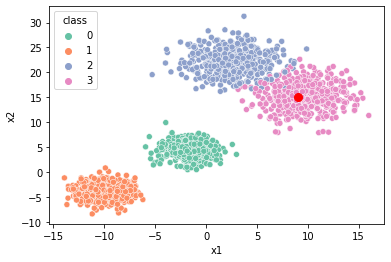

In [7]:
instance2explain = {'x1':9,'x2':15, 'class':3}
#instance2explain = {'x1':4,'x2':20, 'class':0}
X,y = sklearn.datasets.make_blobs(n_samples=1000, centers=2, random_state=1,cluster_std=1.4)
X2,y2 = sklearn.datasets.make_blobs(n_samples=1000, centers=2, random_state=42,cluster_std=2.4)
X2[:,0]+=5
X2[:,1]+=13
X=np.concatenate((X,X2))
y= np.concatenate((y,y2+2))


Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y
graph = sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class',palette='Set2')
graph.axes.plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
plt.savefig('dstree.svg', format='svg',bbox_inches='tight')

### LORE neigh

In [8]:
Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y

target = 'class'
features = [f for f in Xdf.columns if f not in [target]]
train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

blackbox = SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
blackbox.fit(train[features],train[target])

#train.loc[len(train)] = instance2explain
train = pd.concat((train, pd.DataFrame([np.array(list(instance2explain.values()))],columns=instance2explain.keys())), axis=0,ignore_index=True)
dataset = prepare_ds(train, name = 'dataset', class_name='class', discrete=[], label_encoder={})

Zdf,Z = generate_phantom_data(idx_record2explain=len(train)-1, X2E=train[features].values, dataset=dataset, blackbox=blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=True,
            continuous_function_estimation=True)

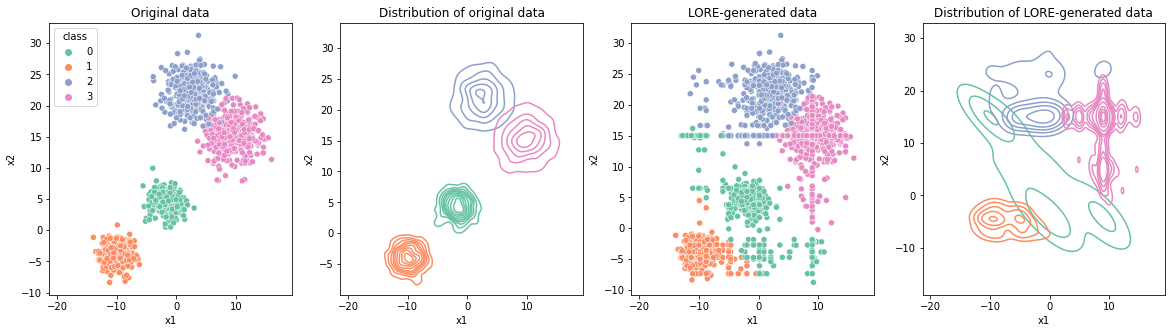

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=True,sharey=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2], legend=False)
sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
sns.kdeplot(data=Zdf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[3],legend=False)
axes[0].set_title('Original data')
axes[1].set_title('Distribution of original data')
axes[2].set_title('LORE-generated data')
axes[3].set_title('Distribution of LORE-generated data')
plt.savefig('./pix/lore-generated-data.pdf', format='pdf',bbox_inches='tight')

In [10]:
X_explain = np.concatenate((np.array(list(instance2explain.values()))[:-1].reshape(1,-1), dataset['X']))
exp_LORE, info_LORE = lore.explain(0, X_explain,
                                   dataset, blackbox,
                                   ng_function=genetic_neighborhood,
                                   discrete_use_probabilities=True,
                                   continuous_function_estimation=False,
                                   returns_infos=True, path='./EXPLAN/yadt/',
                                   sep=';', log=True, depth=10)

rule_LORE = {} 
for i,v in  exp_LORE[0][1].items():
    rule_LORE[i] = [v]


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 10
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 2 class: 1 weight: 0 rows: 1068\n + load time: 0.007911 secs (3.3 MiB/s, 135 K rows/s)\n + indexing ... done\n + total time: 0.009579 secs (2.72 MiB/s, 111.49 K rows/s)\nBuilding 1 tree(s) on 1068 cases\n + tree(s) built\n + size: 35 depth: 6 nf: 2 time: 0.00446 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 6 nf: 2 time: 0.000382 secs\n'


In [11]:
exp_LORE

([{'class': 3},
  {'x1': '>6.532643', 'x2': '-0.82784< x2 <=20.426761'},
  [499.0, 1.3]],
 [{'x2': '<=-0.82784'}])

### EXPLAN neigh

In [12]:
from explan import DataGeneration,DataSelection,DataBalancing
i2e = train.iloc[len(train)-1][features].values
dense_samples = DataGeneration(i2e, blackbox, dataset, 3000)
# Representative data selection step
representative_samples = DataSelection(i2e, blackbox, dense_samples, 250)
# Data balancing step
neighborhood_data = DataBalancing(blackbox, representative_samples, dataset)

Ndf = pd.DataFrame(neighborhood_data, columns=features)
Ndf[target] = blackbox.predict(Ndf[features])

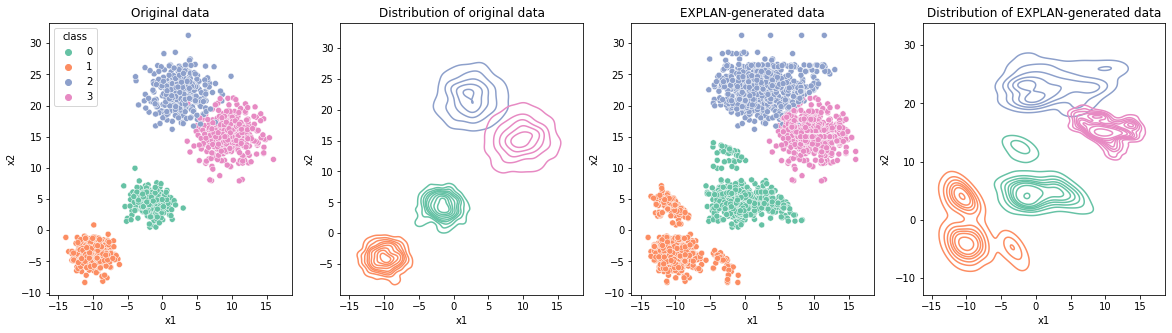

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=True,sharey=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2],legend=False)
sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
sns.kdeplot(data=Ndf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[3],legend=False)
axes[0].set_title('Original data')
axes[1].set_title('Distribution of original data')
axes[2].set_title('EXPLAN-generated data')
axes[3].set_title('Distribution of EXPLAN-generated data')
plt.savefig('./pix/explan-generated-data.pdf', format='pdf',bbox_inches='tight')

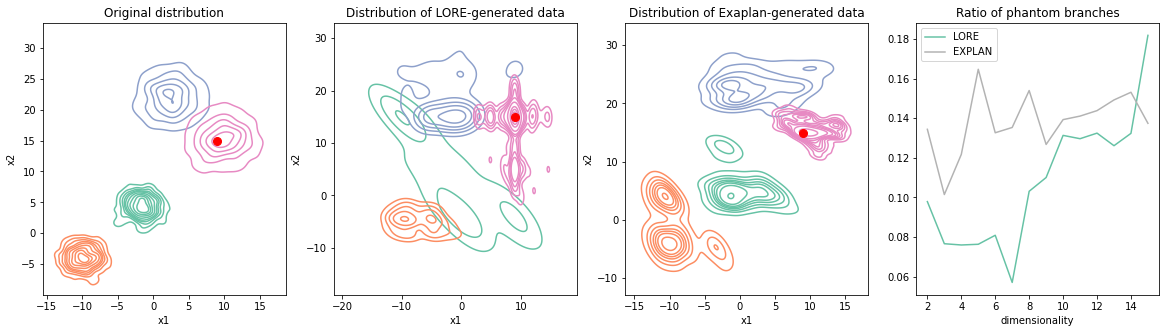

In [14]:
sdf = pd.read_csv('./results/phantoms.csv')
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=False,sharey=False)
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[0],legend=False)
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2], legend=False)
#sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
sns.kdeplot(data=Zdf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
sns.kdeplot(data=Ndf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[2],legend=False)
sdf.groupby('dimensionality')[['phantom_ratio_lore','phantom_ratio_explan']].mean().plot(ax=axes[3], cmap='Set2')

axes[0].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[1].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[2].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[0].set_title('Original distribution')
axes[1].set_title('Distribution of LORE-generated data')
axes[2].set_title('Distribution of Exaplan-generated data')
axes[3].set_title('Ratio of phantom branches')
axes[3].legend(['LORE','EXPLAN'])
plt.savefig('./pix/phantom-generated-data.pdf', format='pdf',bbox_inches='tight')

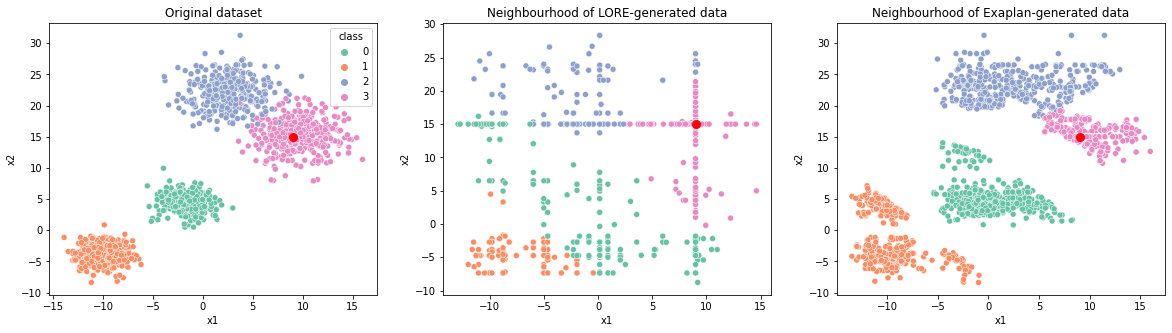

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5),sharex=False,sharey=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
#sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[0],legend=False)
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2], legend=False)
sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[1], legend=False)
#sns.kdeplot(data=Zdf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)

axes[0].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[1].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[2].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[0].set_title('Original dataset')
axes[1].set_title('Neighbourhood of LORE-generated data')
axes[2].set_title('Neighbourhood of Exaplan-generated data')
plt.savefig('./pix/neighbourhood-generated-data.pdf', format='pdf',bbox_inches='tight')

In [16]:
exp_EXPLAN, info_EXPLAN = explan.Explainer(np.array(list(instance2explain.values()))[:-1],
                                               blackbox,
                                               dataset,
                                               N_samples=3000,
                                               tau=200,depth=10)
rule_EXPLAN = {} 
for i,v in  exp_EXPLAN[1].items():
    rule_EXPLAN[i] = [v]

exp_EXPLAN

./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 10
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 2 class: 1 weight: 0 rows: 1388\n + load time: 0.006453 secs (8.01 MiB/s, 215.09 K rows/s)\n + indexing ... done\n + total time: 0.010489 secs (4.92 MiB/s, 132.32 K rows/s)\nBuilding 1 tree(s) on 1388 cases\n + tree(s) built\n + size: 23 depth: 6 nf: 2 time: 0.004841 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 6 nf: 2 time: 0.000245 secs\n'


[{'class': 3},
 {'x2': '10.177488< x2 <=17.967751', 'x1': '>4.713628'},
 [340.0, 1.3]]

### LUX neigh

In [17]:
new_cluster = train[train[target]==1]
new_cluster.loc[:,'x1'] += 15
new_cluster.loc[:,'x2'] -=  5
new_cluster.loc[:,target] = 0

train_nc = pd.concat((new_cluster,train),ignore_index=True)

In [ ]:
lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50)
X_train_sample_base_local, _ = lux.create_sample_bb(train_nc[features], blackbox.predict(train_nc[features]),[train_nc.iloc[len(train_nc)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=False, class_names=[0,1,2,3],density_sampling=False, radius_sampling=False, 
                                         oversampling=False,parity_strategy='local',
                                         representative='centroid')

lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50)
X_train_sample_inverse_local, _ = lux.create_sample_bb(train_nc[features], blackbox.predict(train_nc[features]),[train_nc.iloc[len(train_nc)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1,2,3],density_sampling=False, radius_sampling=False, 
                                         oversampling=False,parity_strategy='local',
                                         representative='centroid')

lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50) #added OS=both, added classifier
X_train_sample_density_local, _ = lux.create_sample_bb(train_nc[features], blackbox.predict(train_nc[features]),[train_nc.iloc[len(train_nc)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1,2,3],
                                                       density_sampling=False, radius_sampling=False, 
                                         oversampling=True,parity_strategy='local',  #chamngd to true oversampling from original
                                         representative='centroid')

# lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50,oversampling_strategy='both')
# X_train_sample_density_local_shapsampling, _ = lux.create_sample_bb(train_nc[features], blackbox.predict(train_nc[features]),[train_nc.iloc[len(train_nc)-1][features].values],X_importances = None, 
#                                          exclude_neighbourhood=False, use_parity=True, 
#                                          inverse_sampling=True, class_names=[0,1,2,3],density_sampling=True, radius_sampling=False, 
#                                          oversampling=True,parity_strategy='local',
#                                          representative='centroid')
#nearest optics based concept, measure distance, exclude everyhing larger than this threshold


lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50)
X_train_sample_base, _ = lux.create_sample_bb(train_nc[features], blackbox.predict(train_nc[features]),[train_nc.iloc[len(train_nc)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=False, class_names=[0,1,2,3],density_sampling=False, radius_sampling=False, 
                                         oversampling=False,parity_strategy='global',
                                         representative='centroid')

lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50)
X_train_sample_inverse, _ = lux.create_sample_bb(train_nc[features], blackbox.predict(train_nc[features]),[train_nc.iloc[len(train_nc)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1,2,3],density_sampling=False, radius_sampling=False, 
                                         oversampling=False,parity_strategy='global',
                                         representative='centroid')

lux = LUX(predict_proba = blackbox.predict_proba,classifier=blackbox, oversampling_strategy='both',
          neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=2)
X_train_sample_density, _ = lux.create_sample_bb(train_nc[features], blackbox.predict(train_nc[features]),[train_nc.iloc[len(train_nc)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1,2,3],density_sampling=False, radius_sampling=False, 
                                         oversampling=True,parity_strategy='global',
                                         representative='centroid')
#nearest optics based concept, measure distance, exclude everyhing larger than this threshold



In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10),sharex=False,sharey=False)
palette = dict(zip(train['class'].unique(),sns.color_palette('Set2',train['class'].nunique())))
train_nc[target] = blackbox.predict(train_nc[features])
graph = sns.scatterplot(data=train_nc,x='x1', y='x2', hue='class',palette=palette, ax=axes[0][0])
Zdf_lux = pd.DataFrame(X_train_sample_base_local, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette=palette,ax=axes[0][1], legend=False)

graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())

Zdf_lux = pd.DataFrame(X_train_sample_inverse_local, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette=palette,ax=axes[0][2], legend=False)

graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())

Zdf_lux = pd.DataFrame(X_train_sample_density_local, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette=palette,ax=axes[0][3], legend=False)
axes[0][0].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[0][1].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[0][2].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[0][3].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)

graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())


graph = sns.scatterplot(data=train_nc,x='x1', y='x2', hue='class',palette=palette, ax=axes[1][0])
Zdf_lux = pd.DataFrame(X_train_sample_base, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette=palette,ax=axes[1][1], legend=False)

graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())

Zdf_lux = pd.DataFrame(X_train_sample_inverse, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette=palette,ax=axes[1][2], legend=False)

graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())

Zdf_lux = pd.DataFrame(X_train_sample_density, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette=palette,ax=axes[1][3], legend=False)
axes[1][0].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[1][1].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[1][2].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[1][3].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)

graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())

axes[0][0].set_title('Original dataset')
axes[0][1].set_title('Base stratified neighbourhood')
axes[0][2].set_title('Inversly sampled neighbourhood')
axes[0][3].set_title('Density-based expansion of neighbourhood')
plt.savefig('./pix/neighbourhood-lux-data.pdf', format='pdf',bbox_inches='tight')
#plt.savefig('./pix/neighbourhood-lux-data.svg', format='svg',bbox_inches='tight')

## Counterfactual generation

In [20]:
def noproba_predictor(x, clf):
    preds = clf.predict_proba(x)
    hot = np.argmax(preds,axis=1)
    result = np.zeros(preds.shape)
    for i in range(0,len(result)):
        result[i,hot[i]] = 1
    return result

In [21]:
instance2explain['x2']=17

In [22]:
luxpure = LUX(predict_proba = lambda x : noproba_predictor(x,clf=blackbox),  neighborhood_size=0.3,max_depth=3,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=20)
luxpure.fit(train_nc[features], train_nc[target],(list(instance2explain.values())[:-1]),X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, oblique=False,
                                         inverse_sampling=True, class_names=[0,1,2,3],density_sampling=True, radius_sampling=False, 
                                         oversampling=True,prune=True,parity_strategy='global',
                                         representative='centroid')


In [23]:
ei = np.array(list(instance2explain.values())[:-1]).reshape(1,-1)
luxpure.justify(ei)[0]

'IF x1 >=3.4075273275375366 AND x2 <17.76985454559326 AND x2 >=7.9155495166778564 THEN class = 3 # 1.0\n'

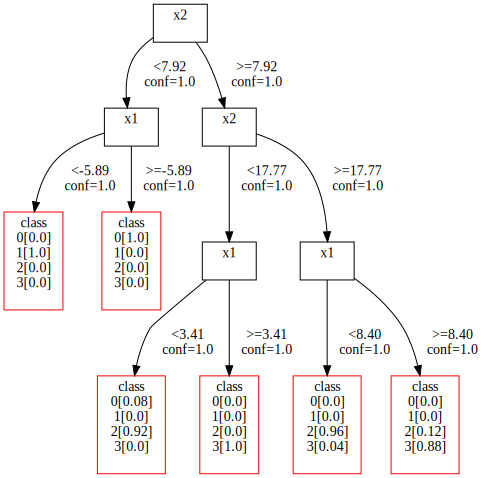

In [24]:
#prind the uncertain local tree for the given instance
import graphviz
luxpure.uid3.tree.save_dot('./pix/F2_tree-pure.dot',fmt='.2f')
graphviz.Source.from_file('./pix/F2_tree-pure.dot')

In [25]:
lux = LUX(predict_proba = lambda x : noproba_predictor(x,clf=blackbox),classifier=blackbox,  oversampling_strategy='importance',neighborhood_size=0.3,max_depth=3,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=20)
lux.fit(train_nc[features], train_nc[target],(list(instance2explain.values())[:-1]),X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, oblique=True,
                                         inverse_sampling=True, class_names=[0,1,2,3],density_sampling=True, radius_sampling=False, 
                                         oversampling=True,prune=True,parity_strategy='global',
                                         representative='centroid')


Done 10.804749340369392 upsampling


Exact explainer: 8949it [01:04, 117.04it/s]                                                                                                                                
Exact explainer: 5290it [00:35, 106.22it/s]                                                                                                                                
Exact explainer: 4072it [00:28, 91.75it/s]                                                                                                                                 
Exact explainer: 3660it [00:26, 85.83it/s]                                                                                                                                 
Exact explainer: 2507it [00:18, 60.94it/s]                                                                                                                                 
Exact explainer: 2501it [00:17, 60.15it/s]                                                                                                  

In [26]:
ei = np.array(list(instance2explain.values())[:-1]).reshape(1,-1)
lux.justify(ei)[0]

'IF x2 < 1.0981245096727301 * x1+11.741595295656325 AND x2 >=7.95315408706665 AND x2 >= -1.9808590280029925 * x1+10.541812766862849 THEN class = 3 # 0.9972\n'

In [27]:
pp = np.argmax(blackbox.predict_proba(train_nc[features]),axis=1)
lpp = lux.predict(train_nc[features])

In [28]:
mask = (pp==lpp)
bg = train_nc[mask]
bg.shape

(1664, 3)

In [29]:
cf = lux.counterfactual(ei, train_nc[features], counterfactual_representative='nearest', topn=1)[0]
print(f"Counterfactual for {ei} to change from class {lux.predict(ei)[0]} to class {cf['prediction']}: \n{cf['counterfactual']}")

Counterfactual for [[ 9 17]] to change from class 3 to class 2: 
x1     6.922731
x2    19.446083
Name: 1411, dtype: float64


In [30]:
cf['rule']

{'x2': ['>=16.7456693649292', '>= 1.0981245096727301 * x1+11.741595295656325']}

In [31]:
arrow = cf['counterfactual'].values-ei
arrow

array([[-2.07726883,  2.44608269]])

In [32]:
cf_medoid = lux.counterfactual(ei, train_nc[features], counterfactual_representative='medoid', topn=1)[0]
print(f"Counterfactual for {ei} to change from class {lux.predict(ei)[0]} to class {cf['prediction']}: \n{cf_medoid['counterfactual']}")

Counterfactual for [[ 9 17]] to change from class 3 to class 2: 
x1     2.503387
x2    22.127040
Name: 1482, dtype: float64


In [33]:
arrow_medoid = cf_medoid['counterfactual'].values-ei
arrow_medoid

array([[-6.49661274,  5.12703955]])

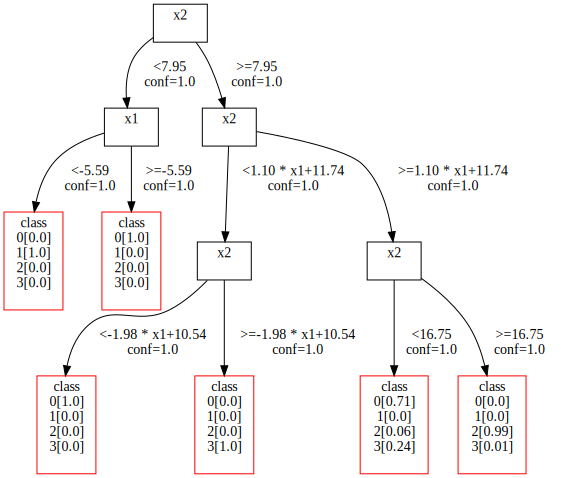

In [34]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('./pix/F2_tree-cf.dot',fmt='.2f')
graphviz.Source.from_file('./pix/F2_tree-cf.dot')

In [35]:
ei = np.array(list(instance2explain.values())[:-1]).reshape(1,-1)
lux.justify(ei)[0]

'IF x2 < 1.0981245096727301 * x1+11.741595295656325 AND x2 >=7.95315408706665 AND x2 >= -1.9808590280029925 * x1+10.541812766862849 THEN class = 3 # 0.9972\n'

In [36]:
i2edf = pd.DataFrame(ei, columns = features)
cfmedoid = cf_medoid['counterfactual'].to_frame().T
cfmedoid[target]= blackbox.predict(cfmedoid)
i2edf[target]= blackbox.predict(i2edf)

In [47]:
train.query("x2 < 1.0981245096727301 * x1+11.741595295656325 and x2 >=7.95315408706665 and x2 < -1.9808590280029925 * x1+10.541812766862849")

,x1,x2,class


Diving into confition <7.95
Diving into confition <-5.59
   class  samples
0      1      335
Diving into confition >=-5.59
   class  samples
0      0      339
1      3        1
Diving into confition >=7.95
Diving into confition <1.10 * x1+11.74
Diving into confition <-1.98 * x1+10.54
Empty DataFrame
Columns: [class, samples]
Index: []


ValueError: min() arg is an empty sequence

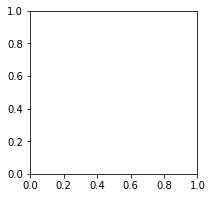

In [43]:
import graphviz
from graphviz import Source
from IPython.display import SVG, Image

#counterfactual

lux.uid3.tree.save_dot('./pix/F3_tree-cf-visual.dot',fmt='.2f',visual=True, background_data=train, instance2explain = i2edf, counterfactual=cfmedoid)
gvz=graphviz.Source.from_file('./pix/F3_tree-cf-visual.dot')
!dot -Tpng ./pix/F3_tree-cf-visual.dot > tree.png
Image('tree.png')

In [39]:
Zdf_lux['LUX predictions'] = lux.predict(Zdf_lux)
Zdf_lux['Blackbox predictions'] = blackbox.predict(Zdf_lux[features])

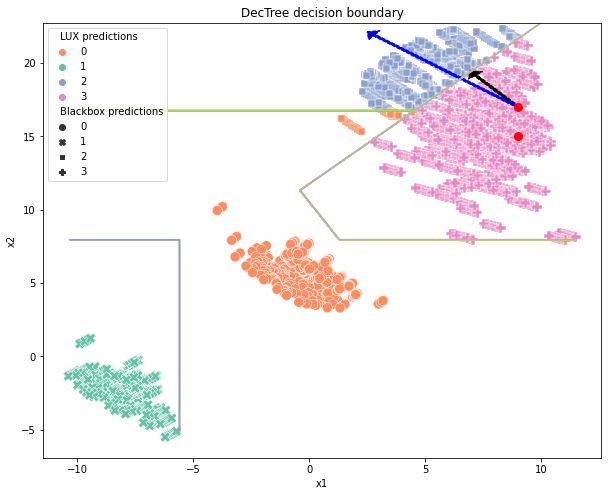

In [52]:
fig, ax = plt.subplots(figsize=(10,8))
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='LUX predictions',palette=palette, legend=True, style='Blackbox predictions',ax=ax)
ax.plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
ax.arrow(ei.ravel()[0],ei.ravel()[1],arrow[0][0],arrow[0][1],head_width=0.8, head_length=0.4,length_includes_head=True,linestyle='--', width=0.14, color='k')
ax.arrow(ei.ravel()[0],ei.ravel()[1],arrow_medoid[0][0],arrow_medoid[0][1],head_width=0.8, head_length=0.4,length_includes_head=True,linestyle='--', width=0.14, color='blue')
graph_lux.collections[0].set_sizes([100])    
XX = Zdf_lux.sample(500)
decision_boundary(lux,train.iloc[len(train)-1], 
                  #Zdf_lux[features],Zdf_lux[target],
                  XX[features],XX[target],
                  f1='x1',f2='x2', dec_only=True, ax=ax)

plt.savefig('./pix/F2_neighbourhood-lux-data.svg', format='svg',bbox_inches='tight')
#plt.savefig('./pix/F2_neighbourhood-lux-data.pdf', format='pdf',bbox_inches='tight')

In [ ]:
sns.color_palette("Set2")[1]

In [ ]:
color1 = sns.color_palette("Set2")[0]
color0 = sns.color_palette("Set2")[1]
color2 = sns.color_palette("Set2")[2]
color3 = sns.color_palette("Set2")[3]

In [ ]:
"".join([f'{int(c*255):0x}' for c in color0])


In [ ]:
"".join([f'{int(c*255):0x}' for c in color1])

In [ ]:
"".join([f'{int(c*255):0x}' for c in color2])

In [ ]:
"".join([f'{int(c*255):0x}' for c in color3])

## Example of Greedy algorithm vs SHAP-powered tree (shap-powered tree is less complicated)

In [ ]:
#todo; the iris dataset the complexity as a number of features used
#does it improve the consistency with shap? it does not have to?
a = np.random.multivariate_normal( mean=[0, 0], cov=[[0.05, 0], [0, 0.05]], size=100) #0
al = np.zeros(100)
b = np.random.multivariate_normal( mean=[1, 1], cov=[[0.05, 0], [0, 0.05]], size=100) #0
bl = np.zeros(100)
c = np.random.multivariate_normal( mean=[0, 1], cov=[[0.05, 0], [0, 0.05]], size=100) #1
cl = np.ones(100)
d = np.random.multivariate_normal( mean=[1, 0], cov=[[0.05, 0], [0, 0.05]], size=100) #1
dl = np.ones(100)
noise = np.array([np.random.choice(np.arange(0, 2), p=[0.6,0.4]) for i in range(0,400)])
labels = np.concatenate((al,bl,cl,dl))
xor = np.concatenate((a,b,c,d))


# a = np.random.multivariate_normal( mean=[0, 0], cov=[[0.05, 0], [0, 0.05]], size=300) #0
# al = np.zeros(300)
# noise = np.array([np.random.choice(np.arange(0, 2), p=[0.6,0.4]) for i in range(0,400)])
# labels = np.concatenate((al,cl))
# xor = np.concatenate((a,c))

#between
# a = np.random.multivariate_normal( mean=[0, 0], cov=[[0.05, 0], [0, 0.05]], size=300) #0
# al = np.zeros(300)
# d = np.random.multivariate_normal( mean=[0, 3], cov=[[0.05, 0], [0, 0.05]], size=300) #0
# dl = np.zeros(300)
# noise = np.array([np.random.choice(np.arange(0, 2), p=[0.6,0.4]) for i in range(0,700)])
# labels = np.concatenate((al,cl,dl))
# xor = np.concatenate((a,c,d))

#3classes
# a = np.random.multivariate_normal( mean=[0, 0], cov=[[0.05, 0], [0, 0.05]], size=100) #0
# al = np.ones(100)*2
# b = np.random.multivariate_normal( mean=[2, 0], cov=[[0.05, 0], [0, 0.05]], size=100) #0
# bl = np.zeros(100)
# noise = np.array([np.random.choice(np.arange(0, 2), p=[0.6,0.4]) for i in range(0,300)])
# labels = np.concatenate((al,cl,bl))
# xor = np.concatenate((a,c,b))


noise_labels = np.abs(labels-noise)
xornoise = np.concatenate((xor, noise_labels.reshape(-1,1)), axis=1)
dataset = np.concatenate((xornoise, labels.reshape(-1,1)),axis=1)

d2 = False
if d2:
    dataset = np.concatenate((xor, labels.reshape(-1,1)),axis=1)



In [ ]:
if d2:
    xords = pd.DataFrame(dataset, columns=['x1','x2','class'])
else:
    xords = pd.DataFrame(dataset, columns=['x1','x2','x3','class'])
    

In [ ]:
xords[target] = xords[target].astype(int)

In [ ]:
train, test = train_test_split(xords, random_state=42)
clf = MLPClassifier()#GradientBoostingClassifier(random_state=42)# svm.SVC(probability=True, random_state=rs)
clf.fit(train[features],train[target])
clf.score(test[features],test[target])

In [ ]:
i2e = train.iloc[len(train)-1][features].values.reshape(1,-1)
plt.figure(figsize=(12,9))
graph=sns.scatterplot(data=xords,x='x1',y='x2',hue='class',palette='Set2')
graph.collections[0].set_sizes([50])      
features = [f for f in xords.columns if f not in ['class']]
target = 'class'
graph.axes.plot(i2e[0][0], i2e[0][1], 'or', markersize=8)
plt.title('Projection of a dataset to 2D. Third dimension contain noise.')
plt.savefig('./pix/F1_scatterplot.pdf', format='pdf',bbox_inches='tight')

In [ ]:
# def noproba_predictor(x):
#     preds = clf.predict_proba(x)
#     hot = np.argmax(preds,axis=1)
#     result = np.zeros(preds.shape)
#     for i in range(0,len(result)):
#         result[i,hot[i]] = 1
#     return result

# lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=int(len(train)*0.8),max_depth=2,  node_size_limit = 10, grow_confidence_threshold = 0 )
# lux.fit(train[features], train[target], instance_to_explain=i2e,class_names=[0,1],n_jobs=1,inverse_sampling=True, density_sampling=True, use_parity=True, oversampling=True)

# #see the justification of the instance being classified for a given class
# lux.justify(np.array(i2e))

In [ ]:
# #prind the uncertain local tree for the given instance
# import graphviz
# lux.uid3.tree.save_dot('./pix/F1_tree-simple.dot',fmt='.2f')
# graphviz.Source.from_file('./pix/F1_tree-simple.dot')

## SHAP values

In [ ]:
# import shap
# shap.initjs()

# explainer = shap.KernelExplainer(clf.predict_proba, train[features])
# explainer =shap.Explainer(clf.predict_proba, train[features])
# shap_values_o = explainer(train[features])

In [ ]:
# shap_values=[sv for sv in np.moveaxis(shap_values_o.values, 2,0)]

In [ ]:
# shap.summary_plot(shap_values, features=None, feature_names=features, max_display=None)

In [ ]:
# barshap = abs(shap_values_o.values).mean(0).mean(1)
# sdf = pd.DataFrame(barshap, index=['x1','x2','x3'])
# sdf.plot.barh(legend=False,cmap='Set2', figsize=(10,3))
# plt.title('Shap values for balckbox classifier')
# plt.savefig('./pix/F1_shap-values-blackbox.pdf', format='pdf',bbox_inches='tight')

In [131]:
# lux = LUX(predict_proba = clf.predict_proba, classifier=clf,neighborhood_size=int(len(train)*0.6),max_depth=2,  node_size_limit = 2, grow_confidence_threshold = 0 )
# lux.fit(train[features], train[target], instance_to_explain=i2e,class_names=[0,1],n_jobs=1,oblique=True,inverse_sampling=True, use_parity=True, oversampling=False, parity_strategy='global')

# #see the justification of the instance being classified for a given class
# lux.justify(np.array(i2e))

In [132]:
# #prind the uncertain local tree for the given instance
# import graphviz
# lux.uid3.tree.save_dot('./pix/F1_tree-shapobliq.dot',fmt='.2f')
# graphviz.Source.from_file('./pix/F1_tree-shapobliq.dot')

## Example of uncertainty incorporation in LUX (explaning why model made predictio when model is uncertain of its decision)

## Example of data generation  (true paterns visible in the data are hidden) -- NO DATA GENERATION, OR SMART GENERATION THAT DOES NOT CHANGE DISTRIBUTION

### LORE

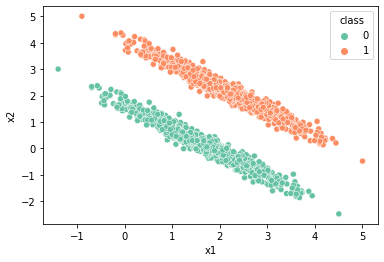

In [133]:
X,y = sklearn.datasets.make_blobs(n_samples=1000, centers=1, random_state=42)
transformation = [[0.4, -0.3], [0.4, -0.2]]
transformation =[[0.8, -0.8], [0.4, -0.2]]
X = np.dot(X, transformation)
X2 = X.copy()
X2[:,0]+=0.5
X2[:,1]+=2
X=np.concatenate((X,X2))
y= np.concatenate((y,y+1))


Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y
graph = sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class',palette='Set2')

In [134]:

instance2explain = {'x1':1.5,'x2':-0.5, 'class':0}
instance2explain = {'x1':0,'x2':1.5, 'class':0}
#instance2explain = {'x1':0,'x2':1, 'class':0}


# X,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.05, random_state=0)
# X,y= sklearn.datasets.make_classification(n_samples=1000, n_features=2, random_state=3,
#                                               n_informative=2, n_redundant=0, n_repeated=0, n_clusters_per_class=2,
#                                               n_classes=2)

X,y = sklearn.datasets.make_blobs(n_samples=500, centers=1, random_state=42)
transformation = [[0.4, -0.3], [0.4, -0.2]]
transformation =[[0.8, -0.8], [0.4, -0.2]]
X = np.dot(X, transformation)
X2 = X.copy()
X2[:,0]+=0.5
X2[:,1]+=2
X=np.concatenate((X,X2))
y= np.concatenate((y,y+1))


Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y

target = 'class'
features = [f for f in Xdf.columns if f not in [target]]
train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

blackbox = SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
blackbox.fit(train[features],train[target])

#train.loc[len(train)] = instance2explain
train = pd.concat((train, pd.DataFrame([np.array(list(instance2explain.values()))],columns=instance2explain.keys())), axis=0,ignore_index=True)
dataset = prepare_ds(train, name = 'dataset', class_name='class', discrete=[], label_encoder={})

Zdf,Z = generate_phantom_data(idx_record2explain=len(train)-1, X2E=train[features].values, dataset=dataset, blackbox=blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=True,
            continuous_function_estimation=True)

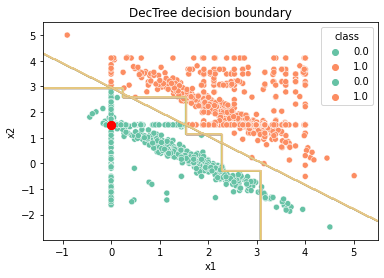

In [135]:
depth = 4
exclf_lore = DecisionTreeClassifier(max_depth=depth)
exclf_lore.fit(Zdf[features], Zdf[target])
    
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=graph.axes)

decision_boundary(exclf_lore,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)
decision_boundary(blackbox,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)

### Explan

In [136]:
from explan import DataGeneration,DataSelection,DataBalancing
i2e = train.iloc[len(train)-1][features].values
dense_samples = DataGeneration(i2e, blackbox, dataset, 3000)
# Representative data selection step
representative_samples = DataSelection(i2e, blackbox, dense_samples, 250)
# Data balancing step
neighborhood_data = DataBalancing(blackbox, representative_samples, dataset)

Ndf = pd.DataFrame(neighborhood_data, columns=features)
Ndf[target] = blackbox.predict(Ndf[features])

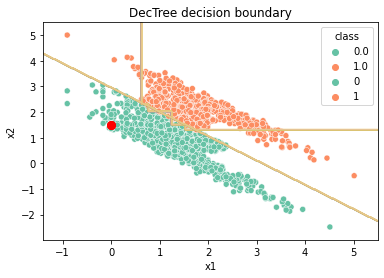

In [137]:
depth = 4
exclf_expl = DecisionTreeClassifier(max_depth=depth)
exclf_expl.fit(Ndf[features], Ndf[target])
    
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=graph.axes)

decision_boundary(exclf_expl,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)
decision_boundary(blackbox,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)

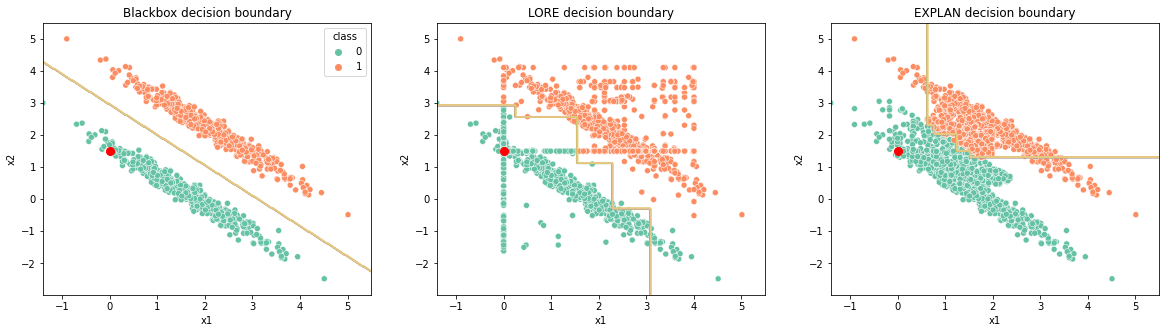

In [138]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5),sharex=False,sharey=False)
sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class',palette='Set2',ax=axes[0])
decision_boundary(blackbox,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[0])


sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[1], legend=False)
sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[1], legend=False)
decision_boundary(exclf_lore,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[1])

sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
decision_boundary(exclf_expl,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[2])

axes[0].set_title('Blackbox decision boundary')
axes[1].set_title('LORE decision boundary')
axes[2].set_title('EXPLAN decision boundary')

plt.savefig('./pix/degenerated-decbounds.pdf', format='pdf',bbox_inches='tight')

### LUX

In [139]:
lux = LUX(predict_proba = blackbox.predict_proba,classifier=blackbox,neighborhood_size=0.3,max_depth=2,  node_size_limit = 2, grow_confidence_threshold = 0,min_samples=50,
         oversampling_strategy='importance')
X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                         oversampling=True,
                                         representative='centroid')

X_train_sample_noos, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                         oversampling=False,
                                         representative='centroid')

Done 2.6289308176100628 upsampling


In [140]:
Zdf_lux = pd.DataFrame(X_train_sample, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)

Zdf_lux_noos = pd.DataFrame(X_train_sample_noos, columns=['x1','x2'])
Zdf_lux_noos[target] = blackbox.predict(Zdf_lux_noos)


only_gnerated = Zdf_lux[~Zdf_lux[features].apply(tuple,1).isin(Zdf_lux_noos[features].apply(tuple,1))]

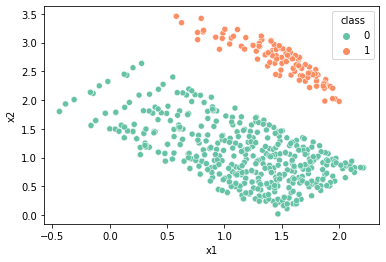

In [141]:
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
graph = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class', palette='Set2')#,ax=graph.axes)
#sns.scatterplot(data=only_gnerated,x='x1', y='x2', marker="$\circ$", ec="face", color='black',ax=graph.axes)

<AxesSubplot:xlabel='x1', ylabel='x2'>

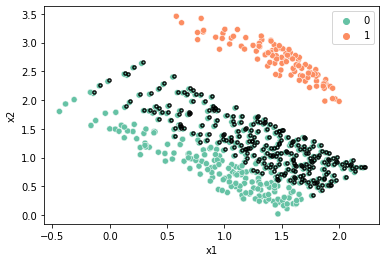

In [142]:
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
graph = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class', palette='Set2')#,ax=graph.axes)
sns.scatterplot(data=only_gnerated,x='x1', y='x2', marker="$\circ$", ec="face", color='black',ax=graph.axes)

### Lux on more complex example

In [55]:
simple=True
if not simple:
    X,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.25, random_state=0)#factor=0.5
    Xdf = pd.DataFrame(X, columns=['x1','x2'])
    Xdf[target] = y
    features = [f for f in Xdf.columns if f not in [target]]
    train, test = train_test_split(Xdf, test_size=0.33, random_state=42)
else:
    X,y = sklearn.datasets.make_blobs(n_samples=500, centers=1, random_state=42)
    transformation = [[0.4, -0.3], [0.4, -0.2]]
    transformation =[[0.8, -0.8], [0.4, -0.2]]
    X = np.dot(X, transformation)
    X2 = X.copy()
    X2[:,0]+=0.5
    X2[:,1]+=2
    X=np.concatenate((X,X2))
    y= np.concatenate((y,y+1))


    Xdf = pd.DataFrame(X, columns=['x1','x2'])
    Xdf['class'] = y

    target = 'class'
    features = [f for f in Xdf.columns if f not in [target]]
    train, test= train_test_split(Xdf, test_size=0.33, random_state=42)


blackbox = GradientBoostingClassifier()#xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')#LogisticRegression()
blackbox.fit(train[features], train[target])

GradientBoostingClassifier()

In [56]:
dataset = prepare_ds(train, name = 'dataset', class_name='class', discrete=[], label_encoder={})

Zdf_complex,Z = generate_phantom_data(idx_record2explain=len(train)-1, X2E=train[features].values, dataset=dataset, blackbox=blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=True,
            continuous_function_estimation=True)

In [57]:
i2e = train.iloc[len(train)-1][features].values
dense_samples = DataGeneration(i2e, blackbox, dataset, 3000)
# Representative data selection step
representative_samples = DataSelection(i2e, blackbox, dense_samples, 250)
# Data balancing step
neighborhood_data = DataBalancing(blackbox, representative_samples, dataset)

Ndf_complex = pd.DataFrame(neighborhood_data, columns=features)
Ndf_complex[target] = blackbox.predict(Ndf_complex[features])

In [58]:
from lux.lux import LUX

In [59]:
lux = LUX(predict_proba = blackbox.predict_proba, classifier=blackbox,neighborhood_size=0.3,max_depth=2,  node_size_limit = 2, grow_confidence_threshold = 0 ,oversampling_strategy='importance',min_samples=5 ,min_generate_samples=0.9)
X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True,
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=False, 
                                         oversampling=True,
                                         representative='centroid')

X_train_sample_noos, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                         oversampling=False,
                                         representative='centroid')

Zdf_lux = pd.DataFrame(X_train_sample, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)

Zdf_lux_noos = pd.DataFrame(X_train_sample_noos, columns=['x1','x2'])
Zdf_lux_noos[target] = blackbox.predict(Zdf_lux_noos)


only_gnerated = Zdf_lux[~Zdf_lux[features].apply(tuple,1).isin(Zdf_lux_noos[features].apply(tuple,1))]

Done 3.731404958677686 upsampling


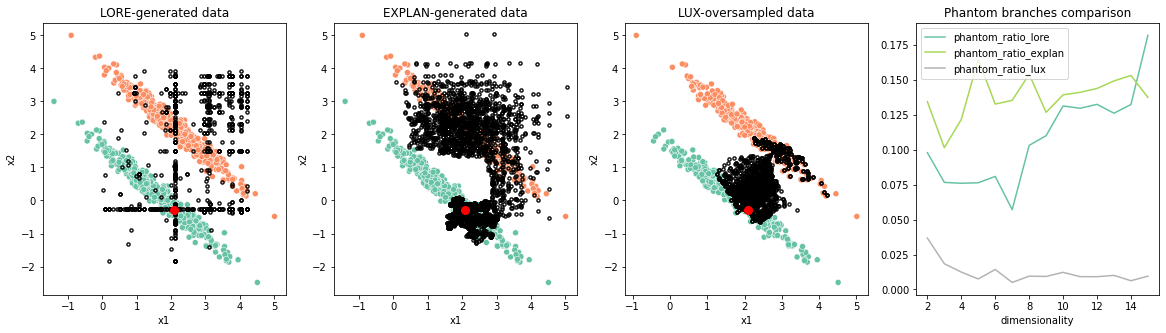

In [60]:
sdf = pd.read_csv('./results/phantoms.csv')
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=False,sharey=False)
#sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class',palette='Set2',ax=axes[0])
#decision_boundary(blackbox,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[0])


sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[0], legend=False)
sns.scatterplot(data=Zdf_complex,x='x1', y='x2',ax=axes[0], legend=False,marker="$\circ$", ec="face", color='black')
#decision_boundary(exclf_lore,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[1])

sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[1], legend=False)
sns.scatterplot(data=Ndf_complex,x='x1', y='x2',ax=axes[1],marker="$\circ$", ec="face", color='black', legend=False)
#decision_boundary(exclf_expl,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[2])

axes[0].plot(i2e[0], i2e[1], 'or', markersize=8)
axes[1].plot(i2e[0], i2e[1], 'or', markersize=8)
axes[2].plot(i2e[0], i2e[1], 'or', markersize=8)

graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2',ax=axes[2],legend=False)
#sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2],legend=False)
#sns.scatterplot(data=only_gnerated,x='x1', y='x2', marker="$\circ$", ec="face", color='black',ax=axes[2],legend=False)
sns.scatterplot(data=X_train_sample,x='x1', y='x2', marker="$\circ$", ec="face", color='black',ax=axes[2],legend=False)
sdf.groupby('dimensionality')[['phantom_ratio_lore','phantom_ratio_explan','phantom_ratio_lux']].mean().plot(ax=axes[3], cmap='Set2')



axes[0].set_title('LORE-generated data')
axes[1].set_title('EXPLAN-generated data')
axes[2].set_title('LUX-oversampled data')
axes[3].set_title('Phantom branches comparison')

#plt.savefig('./pix/lux-oversampling.png', format='png',bbox_inches='tight')
plt.savefig('./pix/lux-oversampling.pdf', format='pdf',bbox_inches='tight')

In [149]:
X_train_sample.shape

(1030, 2)

In [278]:

X_train_sample['class'] = np.random.randint(0,4,len(X_train_sample))#blackbox.predict(X_train_sample[features])
centroids = X_train_sample.groupby('class').mean().reset_index()
voi = centroids[centroids['class']==0]
voi

,class,x1,x2
0,0,2.367879,0.5388


In [279]:
np.max(abs(centroids[features].values-voi[features].values), axis=0)

array([0.04805845, 0.06908449])

In [280]:
train/train.max()

,x1,x2,class
703,0.522827,0.367870,1.0
311,0.584768,-0.144806,0.0
722,0.488895,0.358214,1.0
629,0.483141,0.342126,1.0
0,0.900185,-0.496266,0.0
...,...,...,...
106,0.207226,0.162630,0.0
270,0.634249,-0.267745,0.0
860,0.260176,0.587262,1.0
435,0.532694,-0.193468,0.0


# Functions

## Branch utilisation (phantom branches)

In [ ]:
# generate neigh with lore, explan
# fit uid3, use counterfactual code genration on real data to see how it goes
def get_covered(rule, dataset, features, categorical=None):
    if categorical is None:
        categorical = [False]*len(features)
    query = []
    if rule == {}:
        return 0,0
    for i,v in rule.items():
        op = '' if  dict(zip(features, categorical))[i] == False else '=='
        query.append(f'{i}{op}'+f'and {i}{op}'.join(v))

    covered = dataset.query(' and '.join(query))
    return covered

def coverage_rules(tree, background_train, background_eval,features):
    rules  = tree.to_dict(reduce=True)

    #filter out rules with class same as not_class
    coever_rules = []
    mingen = None
    numfan = 0
    for rule in rules:
        coever_rules.append(rule)
        #find coverage points from background
        rule['covered'] = len(get_covered(rule['rule'],background_eval, features, None))/len(get_covered(rule['rule'],background_train, features, None))
        #find candidates from background according to counterfactual_representative
        if mingen is None or mingen > rule['covered']:
            mingen=rule['covered']
        if rule['covered'] == 0:
            numfan+=1
    return coever_rules,mingen,numfan,numfan/len(rules)

summary=[]
for f in range(2,20):
    for _ in range(1,10):
        if f > 4:
            f2=int(f/2)
            f3=int(f/3)
            f1=f
        else:
            f1=f2=2
            f3=1
            
        try:
            X,y= sklearn.datasets.make_classification(n_samples=500, n_features=f1, #random_state=3,
                                                           n_informative=f2, n_redundant=0, n_repeated=0, n_clusters_per_class=f3,
                                                           n_classes=3)
            cols = [f'f_{i}' for i in range(0,X.shape[1])]
            Xdf = pd.DataFrame(X, columns=cols)
            Xdf['class'] = y

            target = 'class'
            features = [f for f in Xdf.columns if f not in [target]]
            train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

            blackbox = SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
            blackbox.fit(train[features],train[target])

            #train.loc[len(train)] = instance2explain
            idx = random.randint(0, len(train))
            dataset = prepare_ds(train, name = 'dataset', class_name='class', discrete=[], label_encoder={})


            Zdf,Z = generate_phantom_data(idx_record2explain=idx, X2E=train[features].values, dataset=dataset, blackbox=blackbox,
                        ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
                        discrete_use_probabilities=True,
                        continuous_function_estimation=True)



            i2e = train.iloc[idx][features].values
            dense_samples = DataGeneration(i2e, blackbox, dataset, 3000)
            # Representative data selection step
            representative_samples = DataSelection(i2e, blackbox, dense_samples, 250)
            # Data balancing step
            neighborhood_data = DataBalancing(blackbox, representative_samples, dataset)

            Ndf = pd.DataFrame(neighborhood_data, columns=features)
            Ndf[target] = blackbox.predict(Ndf[features])


            lux = LUX(predict_proba = blackbox.predict_proba, classifier=blackbox,neighborhood_size=0.3,max_depth=2,  node_size_limit = 2, oversampling_strategy='both',
                      grow_confidence_threshold = 0, min_samples=10, )
            X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[idx][features].values],X_importances = None, 
                                                 exclude_neighbourhood=False, use_parity=True, 
                                                 inverse_sampling=True, class_names=[0,1],density_sampling=True, radius_sampling=False, 
                                                 oversampling=True,
                                                 representative='centroid')

            #LORE
            data = Data.parse_dataframe(Zdf)
            uid3 = UId3(max_depth=10,node_size_limit=2)
            uid3.fit(data,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=-1)
            rnum_lore = len(uid3.tree.to_dict())
            crgen,mg,numfan,prop = coverage_rules(uid3.tree, Zdf, train,features=features)

            #EXPLAN
            data = Data.parse_dataframe(Ndf)
            uid3 = UId3(max_depth=10,node_size_limit=2)
            uid3.fit(data,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=-1)
            rnum_explan = len(uid3.tree.to_dict())
            crgen_ep,mg_ep,numfan_ep,prop_ep = coverage_rules(uid3.tree, Ndf, train,features=features)

            ##LUX
            X_train_sample_c = X_train_sample.copy()
            X_train_sample_c[target] = blackbox.predict(X_train_sample_c)
            data = Data.parse_dataframe(X_train_sample_c)
            uid3 = UId3(max_depth=10,node_size_limit=2)
            uid3.fit(data,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=-1)
            rnum_lux = len(uid3.tree.to_dict())
            crgreal,mr,numfanr,propr = coverage_rules(uid3.tree, X_train_sample_c, train,features=features)
            print(f'Num of features {f} Minimal coverage generated {mg}, minimal coverage real {mr}, proportion of phantom: {numfan}')
            summary.append([f,mg,mg_ep,mr,numfan,numfan_ep,numfanr,prop,prop_ep,propr,rnum_lore, rnum_explan, rnum_lux])
        except:
            pass
        
    

Done 1.05 upsampling
OS Botj OK
Num of features 2 Minimal coverage generated 0.19922630560928434, minimal coverage real 0.7142857142857143, proportion of phantom: 0
Done 2.2450331125827816 upsampling
OS Botj OK
Num of features 2 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 1
Done 1.1181818181818182 upsampling
OS Botj OK
Num of features 2 Minimal coverage generated 0.0, minimal coverage real 0.10526315789473684, proportion of phantom: 1
Done 1.0 upsampling
OS Botj OK
Num of features 2 Minimal coverage generated 0.0, minimal coverage real 0.45454545454545453, proportion of phantom: 1
Done 1.2127659574468086 upsampling
OS Botj OK
Num of features 2 Minimal coverage generated 0.0, minimal coverage real 0.6785714285714286, proportion of phantom: 1
Done 1.3689320388349515 upsampling
OS Botj OK
Num of features 2 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 2
Done 1.6063829787234043 upsampling
OS Botj OK
Num of features 2

Exact explainer: 336it [00:24,  7.96it/s]                                                                                                                                  


Done 2.8358208955223883 upsampling
OS Botj OK
Num of features 6 Minimal coverage generated 0.13894324853228962, minimal coverage real 0.0, proportion of phantom: 0


Exact explainer: 336it [00:20,  8.36it/s]                                                                                                                                  


Done 3.8746268656716416 upsampling
OS Botj OK
Num of features 6 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 2


Exact explainer: 336it [00:21,  8.28it/s]                                                                                                                                  


Done 5.51044776119403 upsampling
OS Botj OK
Num of features 6 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 14


Exact explainer: 336it [00:21,  8.28it/s]                                                                                                                                  


Done 3.098507462686567 upsampling
OS Botj OK
Num of features 6 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 1


Exact explainer: 336it [00:13,  6.79it/s]                                                                                                                                  


Done 4.53134328358209 upsampling
OS Botj OK
Num of features 6 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 7


Exact explainer: 336it [00:17,  8.17it/s]                                                                                                                                  


Done 3.7850746268656716 upsampling
OS Botj OK
Num of features 6 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 3


Exact explainer: 336it [00:20,  8.32it/s]                                                                                                                                  


Done 3.946268656716418 upsampling
OS Botj OK
Num of features 6 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 6


Exact explainer: 336it [00:23,  8.12it/s]                                                                                                                                  


Done 7.2477611940298505 upsampling
OS Botj OK
Num of features 6 Minimal coverage generated 0.11632270168855535, minimal coverage real 0.0, proportion of phantom: 0


Exact explainer: 336it [00:22,  8.29it/s]                                                                                                                                  


Done 4.1940298507462686 upsampling
OS Botj OK
Num of features 6 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 3


Exact explainer: 336it [00:30,  7.41it/s]                                                                                                                                  


Done 4.832835820895522 upsampling
OS Botj OK
Num of features 7 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 9


Exact explainer: 336it [00:35,  6.81it/s]                                                                                                                                  


Done 4.626865671641791 upsampling
OS Botj OK
Num of features 7 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 4


Exact explainer: 336it [00:32,  7.04it/s]                                                                                                                                  


Done 3.388059701492537 upsampling
OS Botj OK
Num of features 7 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 5


Exact explainer: 336it [00:29,  7.54it/s]                                                                                                                                  


Done 3.782089552238806 upsampling
OS Botj OK
Num of features 7 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 2


Exact explainer: 336it [00:42,  5.97it/s]                                                                                                                                  


Done 4.2119402985074625 upsampling
OS Botj OK
Num of features 7 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 4


Exact explainer: 336it [00:37,  6.54it/s]                                                                                                                                  


Done 3.9313432835820894 upsampling
OS Botj OK
Num of features 7 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 1


Exact explainer: 336it [00:41,  6.10it/s]                                                                                                                                  


Done 6.480597014925373 upsampling
OS Botj OK
Num of features 7 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 2


Exact explainer: 336it [00:40,  6.17it/s]                                                                                                                                  


Done 3.9074626865671642 upsampling
OS Botj OK
Num of features 7 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 11


Exact explainer: 336it [00:43,  5.92it/s]                                                                                                                                  


Done 7.032835820895523 upsampling
OS Botj OK
Num of features 7 Minimal coverage generated 0.15833333333333333, minimal coverage real 0.0, proportion of phantom: 0


Exact explainer: 336it [01:13,  3.92it/s]                                                                                                                                  


Done 4.552238805970149 upsampling
OS Botj OK
Num of features 8 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 2


Exact explainer: 336it [01:04,  4.37it/s]                                                                                                                                  


Done 3.4746268656716417 upsampling
OS Botj OK
Num of features 8 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 11


Exact explainer: 124it [00:30,  2.70it/s]                                                                                                                                  


Done 2.3252032520325203 upsampling
OS Botj OK
Num of features 8 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 7


Exact explainer: 336it [01:09,  4.13it/s]                                                                                                                                  


Done 4.056716417910447 upsampling
OS Botj OK
Num of features 8 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 5


Exact explainer: 91it [00:22,  2.38it/s]                                                                                                                                   


Done 2.1333333333333333 upsampling
OS Botj OK
Num of features 8 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 4


Exact explainer: 336it [01:25,  3.46it/s]                                                                                                                                  


Done 2.725373134328358 upsampling
OS Botj OK
Num of features 8 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 7


Exact explainer: 336it [01:01,  4.52it/s]                                                                                                                                  


Done 4.570149253731343 upsampling
OS Botj OK
Num of features 8 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 10


Exact explainer: 336it [01:25,  3.47it/s]                                                                                                                                  


Done 4.244776119402985 upsampling
OS Botj OK
Num of features 8 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 1


Exact explainer: 336it [01:10,  4.06it/s]                                                                                                                                  


Done 3.743283582089552 upsampling
OS Botj OK
Num of features 8 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 6


Exact explainer: 336it [02:30,  2.09it/s]                                                                                                                                  


Done 4.2925373134328355 upsampling
OS Botj OK
Num of features 9 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 3


Exact explainer: 336it [03:08,  1.69it/s]                                                                                                                                  


Done 4.75820895522388 upsampling
OS Botj OK
Num of features 9 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 8


Exact explainer: 336it [02:57,  1.79it/s]                                                                                                                                  


Done 5.119402985074627 upsampling
OS Botj OK
Num of features 9 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 14


Exact explainer: 336it [02:39,  1.97it/s]                                                                                                                                  


Done 4.3194029850746265 upsampling
OS Botj OK
Num of features 9 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 4


Exact explainer: 336it [03:09,  1.68it/s]                                                                                                                                  


Done 4.916417910447761 upsampling
OS Botj OK
Num of features 9 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 8


Exact explainer: 336it [02:48,  1.87it/s]                                                                                                                                  


Done 5.158208955223881 upsampling
OS Botj OK
Num of features 9 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 15


Exact explainer: 336it [03:09,  1.68it/s]                                                                                                                                  


Done 4.459701492537313 upsampling
OS Botj OK
Num of features 9 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 19


Exact explainer: 336it [02:30,  2.08it/s]                                                                                                                                  


Done 4.558208955223881 upsampling
OS Botj OK
Num of features 9 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 3


Exact explainer: 336it [03:03,  1.72it/s]                                                                                                                                  


Done 3.6686567164179102 upsampling
OS Botj OK
Num of features 9 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 5


Exact explainer: 336it [06:25,  1.18s/it]                                                                                                                                  


Done 5.462686567164179 upsampling
OS Botj OK
Num of features 10 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 1


Exact explainer: 336it [05:50,  1.08s/it]                                                                                                                                  


Done 4.358208955223881 upsampling
OS Botj OK
Num of features 10 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 5


Exact explainer: 336it [06:15,  1.15s/it]                                                                                                                                  


Done 6.176119402985075 upsampling
OS Botj OK
Num of features 10 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 10


Exact explainer: 336it [05:10,  1.05it/s]                                                                                                                                  


Done 4.519402985074627 upsampling
OS Botj OK
Num of features 10 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 12


Exact explainer: 336it [05:00,  1.08it/s]                                                                                                                                  


Done 4.462686567164179 upsampling
OS Botj OK
Num of features 10 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 10


Exact explainer: 336it [05:31,  1.02s/it]                                                                                                                                  


Done 5.605970149253731 upsampling
OS Botj OK
Num of features 10 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 13


Exact explainer: 336it [06:47,  1.25s/it]                                                                                                                                  


Done 4.597014925373134 upsampling
OS Botj OK
Num of features 10 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 5


Exact explainer: 336it [05:26,  1.01s/it]                                                                                                                                  


Done 4.3373134328358205 upsampling
OS Botj OK
Num of features 10 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 10


Exact explainer: 336it [05:24,  1.00it/s]                                                                                                                                  


Done 3.934328358208955 upsampling
OS Botj OK
Num of features 10 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 5


Permutation explainer: 336it [03:40,  1.45it/s]                                                                                                                            


Done 4.456716417910448 upsampling
OS Botj OK
Num of features 11 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 1


Permutation explainer: 336it [03:10,  1.67it/s]                                                                                                                            


Done 4.588059701492537 upsampling
OS Botj OK
Num of features 11 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 11


Permutation explainer: 336it [02:59,  1.77it/s]                                                                                                                            


Done 3.8298507462686566 upsampling
OS Botj OK
Num of features 11 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 25


Permutation explainer:  60%|█████████████████████████████████████████████████████████████████▍                                           | 201/335 [02:09<01:25,  1.56it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Permutation explainer: 336it [03:33,  1.50it/s]                                                                                                                            


Done 5.650746268656716 upsampling
OS Botj OK
Num of features 12 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 4


Permutation explainer: 336it [03:26,  1.55it/s]                                                                                                                            


Done 4.277611940298508 upsampling
OS Botj OK
Num of features 12 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 8


Permutation explainer: 336it [03:15,  1.63it/s]                                                                                                                            


Done 3.68955223880597 upsampling
OS Botj OK
Num of features 12 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 10


Permutation explainer: 336it [03:21,  1.60it/s]                                                                                                                            


Done 3.8865671641791044 upsampling
OS Botj OK
Num of features 12 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 9


Permutation explainer: 336it [03:27,  1.54it/s]                                                                                                                            


Done 3.8298507462686566 upsampling
OS Botj OK
Num of features 12 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 14


Permutation explainer: 336it [03:37,  1.47it/s]                                                                                                                            


Done 5.250746268656717 upsampling
OS Botj OK
Num of features 12 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 11


Permutation explainer: 336it [03:33,  1.50it/s]                                                                                                                            


Done 3.97910447761194 upsampling
OS Botj OK
Num of features 12 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 12


Permutation explainer: 336it [03:17,  1.61it/s]                                                                                                                            


Done 4.543283582089552 upsampling
OS Botj OK
Num of features 12 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 9


Permutation explainer: 336it [03:31,  1.51it/s]                                                                                                                            


Done 5.122388059701493 upsampling
OS Botj OK
Num of features 13 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 6


Permutation explainer: 336it [03:17,  1.61it/s]                                                                                                                            


Done 4.414925373134328 upsampling
OS Botj OK
Num of features 13 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 10


Permutation explainer: 336it [03:42,  1.44it/s]                                                                                                                            


Done 4.373134328358209 upsampling
OS Botj OK
Num of features 13 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 14


Permutation explainer: 336it [03:40,  1.45it/s]                                                                                                                            


Done 4.33134328358209 upsampling
OS Botj OK
Num of features 13 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 16


Permutation explainer: 336it [03:29,  1.52it/s]                                                                                                                            


Done 4.994029850746268 upsampling
OS Botj OK
Num of features 13 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 3


Permutation explainer: 336it [03:25,  1.56it/s]                                                                                                                            


Done 4.011940298507462 upsampling
OS Botj OK
Num of features 13 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 5


Permutation explainer: 336it [03:16,  1.62it/s]                                                                                                                            


Done 4.13134328358209 upsampling
OS Botj OK
Num of features 13 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 15


Permutation explainer: 336it [03:20,  1.59it/s]                                                                                                                            


Done 5.459701492537313 upsampling
OS Botj OK
Num of features 13 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 9


Permutation explainer: 336it [03:35,  1.49it/s]                                                                                                                            


Done 4.967164179104477 upsampling
OS Botj OK
Num of features 13 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 11


Permutation explainer: 336it [03:31,  1.51it/s]                                                                                                                            


Done 4.776119402985074 upsampling
OS Botj OK


In [ ]:
sdf = pd.DataFrame(summary, columns=['dimensionality','min_cov_lore','min_cov_explan','min_cov_lux','phantom_no_lore','phantom_no_explan',
                                     'phantom_no_lux','phantom_ratio_lore','phantom_ratio_explan','phantom_ratio_lux',
                                     'rules_lore','rules_explan','rules_lux'])
sdf.to_csv('phantoms-shap.csv',index=False)

In [ ]:
sdf = pd.read_csv('phantoms-shap.csv')

In [ ]:
sdf.groupby('dimensionality')[['phantom_no_lore','phantom_no_explan','phantom_no_lux']].mean().plot()

In [ ]:
sdf.groupby('dimensionality')[['phantom_ratio_lore','phantom_ratio_explan','phantom_ratio_lux']].mean().plot()

In [ ]:
sdf.groupby('dimensionality')[[ 'rules_lore','rules_explan','rules_lux']].mean().plot()

## Example of oblique necessity (lineary decbound in DT is counterintuitive fro experts) -- DT DOES NOT ALWAYS CAPTURES WHAT MODEL TRIES TO CAPTURE

## Need for visualization of explanations throuhg the lenses of DS (explanation should be backed by data distribution, otherwise it is missing important informaiton)

In [8]:
sdf['dimensionality'].max()

NameError: name 'sdf' is not defined

## Tradeoff between locla/global by selecting the fraction

# Stability among same instance

In [ ]:
f=8
X,y= sklearn.datasets.make_classification(n_samples=1000, n_features=f, random_state=3,
                                                       n_informative=int(f/2), n_redundant=0, n_repeated=0, n_clusters_per_class=int(f/3),
                                                       n_classes=2)
cols = [f'f_{i}' for i in range(0,X.shape[1])]
Xdf = pd.DataFrame(X, columns=cols)
Xdf['class'] = y

target = 'class'
features = [f for f in Xdf.columns if f not in [target]]
train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

blackbox = SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
blackbox.fit(train[features],train[target])

#train.loc[len(train)] = instance2explain


In [ ]:
idx = 10
i2e = train.iloc[idx][features].values
dataset = prepare_ds(train.copy(), name = 'dataset', class_name='class', discrete=[], label_encoder={})

In [ ]:

rules_temp=[]
stab_stats=[]
stability_data=[]
# EXPLAN hyper-parameters
N_samples = 3000#n_neighbors
tau = 250#int(n_neighbors)/len(np.unique(df[target])
fraction=0.2
uncertain_entropy_evaluator=UncertainEntropyEvaluator()
pos_label = blackbox.predict(np.array(i2e).reshape(1,-1))[0]
for _ in range(0,5):
    # Explaining instance x using EXPLAN
    exp_EXPLAN, info_EXPLAN = explan.Explainer(i2e,
                                               blackbox,
                                               dataset,
                                               N_samples=N_samples,
                                               tau=tau,depth=depth)
    rule_EXPLAN = {} 
    for i,v in  exp_EXPLAN[1].items():
        rule_EXPLAN[i] = [v]

    rule_EXPLAN = split_rule_conditions(rule_EXPLAN)
    #EXPLAN expl e = {'f_2': '0.426178< f_2 <=1.226002', 'f_4': '<=0.608496', 'f_7': '>-0.403450'}

    cov_EXPLAN, acc_EXPLAN, prec_EXPLAN, rec_EXPLAN, f1_EXPLAN = coverage_precision(rule_EXPLAN, test, features, 
                                                                                    [False]*len(features), exp_EXPLAN[0][dataset['class_name']], 
                                                                                    class_label='class')

    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%% LORE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    X_explain = np.concatenate((np.array(i2e).reshape(1,-1), dataset['X']))
    exp_LORE, info_LORE = lore.explain(0, X_explain,
                                       dataset, blackbox,
                                       ng_function=genetic_neighborhood,
                                       discrete_use_probabilities=True,
                                       continuous_function_estimation=False,
                                       returns_infos=True, path='./EXPLAN/yadt/',
                                       sep=';', log=True, depth=depth)

    rule_LORE = {} 
    for i,v in  exp_LORE[0][1].items():
        rule_LORE[i] = [v]

    rule_LORE = split_rule_conditions(rule_LORE)

    cov_LORE, acc_LORE, prec_LORE, rec_LORE, f1_LORE = coverage_precision(rule_LORE, test, features, [False]*len(features), 
                                                                          exp_LORE[0][0][dataset['class_name']], class_label='class')
   
    
    ############################ ANCHOR ######################################
    X_explain = np.concatenate((np.array(i2e).reshape(1,-1), dataset['X']))
    anchor_explainer = fit_anchor(dataset, train[features].values, train[features].values, train[target].values, train[target].values, X_explain)
    exp_Anchor = anchor_explainer.explain_instance(X_explain[0].reshape(1, -1),
                                                                blackbox.predict, threshold=np.max([0.5]+[f for f in [prec_LORE,prec_EXPLAN] if f is not np.nan]))

    anch_depth = min(depth-1,len(exp_Anchor.exp_map['feature'])-1)
    ats_anchor=['f_'+str(f) for f in exp_Anchor.exp_map['feature'][:anch_depth+1]]



    #fit_partial = np.where(np.all(X_explain[:, exp_Anchor.features(anch_depth)] == X_explain[0][exp_Anchor.features(anch_depth)], axis=1))[0]
    #prec_anchor =  (np.mean(clf.predict(X_explain[fit_partial]) == clf.predict(X_explain[0].reshape(1, -1))))
    #cov_anchor = exp_Anchor.exp_map['coverage'][anch_depth]
    #print('Partial anchor test coverage: %.2f' % (fit_partial.shape[0] / float(X_explain.shape[0])))

    rule_Anchor_full = anchor2arule(exp_Anchor)
    rule_Anchor={}
    for i,v in rule_Anchor_full.items():
        if i in ats_anchor[:anch_depth+1]:
            rule_Anchor[i]=[v]

    dfXExplain = build_df2explain(blackbox, X_explain, dataset)
    rule_Anchor = split_rule_conditions(rule_Anchor)

    cov_anchor, acc_anchor, prec_anchor, rec_anchor, f1_anchor = coverage_precision(rule_Anchor, test, features, 
                                                                                    [False]*len(features), pos_label, class_label='class')
        
    
   
    
    ##########################################LUX
    
    lux = LUX(classifier = blackbox,predict_proba = blackbox.predict_proba, 
              neighborhood_size=fraction,max_depth=depth,  node_size_limit = 2, grow_confidence_threshold = 0, min_samples=50)
    X_train_sample, _ = lux.create_sample_bb(train[features], blackbox.predict(train[features]),[np.array(i2e).reshape(1,-1)], categorical=categorical_indicator,
                                                  X_importances = None, exclude_neighbourhood=False, class_names=np.unique(y),
                                                  use_parity=True, inverse_sampling=True, radius_sampling=False,oversampling=True,
                                                 representative='centroid',density_sampling=True,n_jobs=-1)
    lux.attributes_names=X_train_sample.columns
    # lux.fit(train[features], train[target], 
    #         X_importances = None,uncertain_entropy_evaluator=uncertain_entropy_evaluator,oversampling=oversampling,
    #         instance_to_explain=explain_instance,discount_importance=False,radius_sampling=radius_sampling,representative=representative,
    #         use_parity=up, inverse_sampling=ismpl,density_sampling=density_sampling, categorical=categorical_indicator,n_jobs=-1 )

    ## To make it faster, not repeat neighbourhood selection step every time:
    y_train_sample = lux.predict_proba(X_train_sample)
    #limit features here
    uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
    udata = Data.parse_uarff_from_string(uarff)
    print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
    lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
    if lux.classifier is not None:
        lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, classifier=lux.classifier, discount_importance=True,
                                depth=0,beta=1,n_jobs=-1,prune=True,oblique=True,imp=None)
    else:
        lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=True,beta=1,
                                n_jobs=-1,prune=True,oblique=True,imp=False)
        
    
    justification_dict = lux.justify(np.array(i2e).reshape(1,-1), to_dict=True)[0][0]
    rule_lux_shap = justification_dict['rule']
        
    rules_temp.append([np.array(i2e).reshape(1,-1),blackbox.predict(np.array(i2e).reshape(1,-1))[0],rule_EXPLAN, rule_LORE, rule_Anchor,rule_lux_shap])
    
    
results_rules = pd.DataFrame(rules_temp, columns=['explain_instance','true_class','rule_EXPLAN', 'rule_LORE','rule_ANCHOR','rule_LUX'])
stab_stats = [stability_stats(results_rules, rid, train, features, [False]*len(features)) for rid in ['rule_EXPLAN','rule_LORE']]
stability_data.append(['tmp','tmp']+list(np.concatenate(stab_stats)))


In [ ]:
for i in results_rules['explain_instance']:
    print(i)

# Evaluation

In [101]:
from scipy.stats import friedmanchisquare,rankdata,f
import scikit_posthocs as sp
import numpy as np
import Orange 
import pandas as pd

In [102]:
def to_latex(aggregated, aggregated_std, index_name='', caption='',label=''):
    aggregated=aggregated.replace('_','\_')
    aggregated_std=aggregated_std.replace('_','\_')
    print('\\begin{table}')
    print('\\caption{'+caption+'}')
    print('\\label{'+label+'}')
    print('\\begin{tabularx}{\\textwidth}{|X|'+'|'.join(['X']*len(aggregated.columns))+'|}')
    print('\\hline')
    print(index_name+' & '+'&'.join(aggregated.columns))
    print('\\\\ \\hline \\hline')
    for i,row in aggregated.iterrows():
        row_std = aggregated_std.loc[i]
        rowstring = []
        for r,r_std in zip(row,row_std):
            rowstring.append("{:0.2f}".format(r)+' $\pm$ '+"{:0.2f}".format(r_std))
        print(str(i)+' & '+' & '.join(rowstring)+'\\\\ \hline')
    print('\\end{tabularx}\n\\end{table}')

In [103]:
def to_latex_nostd(aggregated, index_name='', caption='',label=''):
    aggregated=aggregated.replace('_','\_')
    print('\\begin{table}')
    print('\\caption{'+caption+'}')
    print('\\label{'+label+'}')
    print('\\begin{tabularx}{\\textwidth}{|X|'+'|'.join(['X']*len(aggregated.columns))+'|}')
    print('\\hline')
    print(index_name+' & '+'&'.join(aggregated.columns))
    print('\\\\ \\hline \\hline')
    for i,row in aggregated.iterrows():
        rowstring = []
        for r in row:
            rowstring.append("{:0.2f}".format(r))
        print(str(i)+' & '+' & '.join(rowstring)+'\\\\ \hline')
    print('\\end{tabularx}\n\\end{table}')

## Real datasets description

In [104]:
import os
import pickle
from sklearn.preprocessing import StandardScaler
import sklearn.datasets

data_characteristics=[]
synthetic=True

nf = 4
SYNTH_BREAK=20
directory = './data/numerical_only/balanced'
i=1
for num_and_cat in  os.listdir(directory):
    if num_and_cat in ['data_Higgs','data_covertype','data_MiniBooNE']:
        continue
    if directory =='./data/numerical_only/balanced':
        (data, y) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
        features = [f'f_{i}' for i in range(0,data.shape[1])]
        categorical_indicator=[False]*len(features)
    elif directory =='./data/num_and_cat/balanced':
        (data, y, categorical_indicator) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
        features = [f'f_{i}' for i in range(0,data.shape[1])]
        density_sampling=False
        categories_data = data[:,categorical_indicator]
        categories=[np.unique(categories_data[:,i]).astype(int) for i in np.arange(categories_data.shape[1])]
    target = 'class'
    
    if synthetic: 
        if nf > SYNTH_BREAK:
            break
        #,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.35, random_state=0)#factor=0.5
        X,y= sklearn.datasets.make_classification(n_samples=250*int(nf), n_features=nf+4, 
                                              n_informative=int(nf/2), n_redundant=int(nf/4), n_repeated=0, n_clusters_per_class=int(nf/2),
                                              n_classes=2)
        features = [f'f_{i}' for i in range(0,X.shape[1])]
        categorical_indicator=[False]*len(features)
        df = pd.DataFrame(X, columns=features)
        df[target] = y
        num_and_cat = f'n_samples={250*int(nf)};n_features={nf+4};n_informative={int(nf/2)};n_redundant={int(nf/4)};n_classes={2};n_clusters={int(nf/2)}'
        directory='synthetic'
        data_characteristics.append(['synthetic_'+str(i),df.shape[0], df.shape[1]-1, int(nf/2),int(nf/4),int(nf/2),sum(y)/len(y)])
        i+=1
    else:
        continuous_indicator = np.logical_not(categorical_indicator)

        df = pd.DataFrame(data,columns=features,dtype=float)
        sc = StandardScaler()
        df.loc[:,df[features].columns[continuous_indicator]]=sc.fit_transform(df[df[features].columns[continuous_indicator]])#normalize(df, axis=0)#sc.fit_transform(df)
        df[target] = y
        data_characteristics.append([num_and_cat,df.shape[0], df.shape[1]-1, sum(y)/len(y)])
    
    nf+=1
    depth = len(features)+4

    if num_and_cat in ['data_Higgs','data_covertype','data_MiniBooNE']:
        continue
        

In [105]:
if synthetic == False:
    ds_desc = pd.DataFrame(data_characteristics, columns=['Dataset name','No of instances','No of features','Class ratio']).set_index('Dataset name')
    print(to_latex_nostd(ds_desc, index_name='Dataset name'))
else:
    ds_desc = pd.DataFrame(data_characteristics, columns=['Dataset name','No of instances','No of features', 'No informative features','No redundant features','No clusetrs per class','Class ratio']).set_index('Dataset name')
    print(to_latex_nostd(ds_desc, index_name='Dataset name'))
    

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|X|X|}
\hline
Dataset name & No of instances&No of features&No informative features&No redundant features&No clusetrs per class&Class ratio
\\ \hline \hline
synthetic_1 & 1000.00 & 8.00 & 2.00 & 1.00 & 2.00 & 0.50\\ \hline
synthetic_2 & 1250.00 & 9.00 & 2.00 & 1.00 & 2.00 & 0.50\\ \hline
synthetic_3 & 1500.00 & 10.00 & 3.00 & 1.00 & 3.00 & 0.50\\ \hline
synthetic_4 & 1750.00 & 11.00 & 3.00 & 1.00 & 3.00 & 0.50\\ \hline
synthetic_5 & 2000.00 & 12.00 & 4.00 & 2.00 & 4.00 & 0.50\\ \hline
synthetic_6 & 2250.00 & 13.00 & 4.00 & 2.00 & 4.00 & 0.50\\ \hline
synthetic_7 & 2500.00 & 14.00 & 5.00 & 2.00 & 5.00 & 0.50\\ \hline
synthetic_8 & 2750.00 & 15.00 & 5.00 & 2.00 & 5.00 & 0.50\\ \hline
synthetic_9 & 3000.00 & 16.00 & 6.00 & 3.00 & 6.00 & 0.50\\ \hline
synthetic_10 & 3250.00 & 17.00 & 6.00 & 3.00 & 6.00 & 0.50\\ \hline
synthetic_11 & 3500.00 & 18.00 & 7.00 & 3.00 & 7.00 & 0.50\\ \hline
synthetic_12 & 3750.00 & 19.00 & 

## Fidelity

In [108]:
subjects =[]
lux = []
explan = []
lore = []
anchor=[]
directory='realx100_deep_prune_oblique_os_shap_densamp_6'

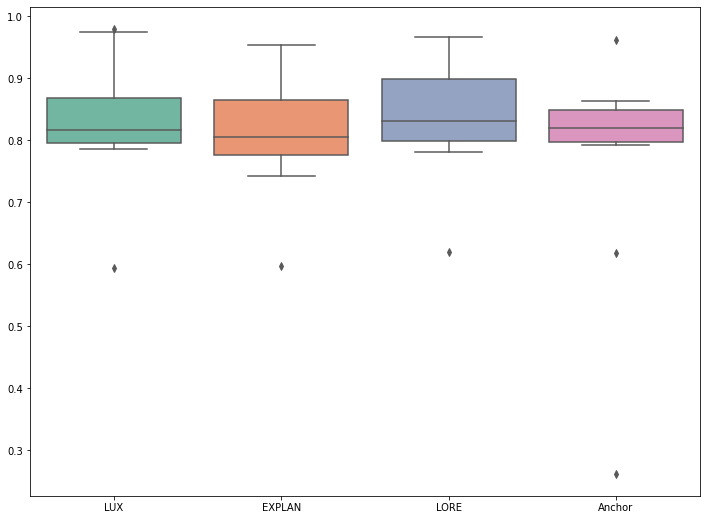

In [109]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import f
fig, ax = plt.subplots(figsize=(12,9))
aggregated = pd.read_csv(f'./results/{directory}/synthx100_local_fid_nn.csv').fillna(0).groupby('dataset')[['f1_shap','f1_EXPLAN','f1_LORE','f1_anchor']].mean()
aggregated.columns=['LUX','EXPLAN','LORE','Anchor']
sns.boxplot(data=aggregated, ax=ax,palette='Set2', notch=False)
plt.savefig('./pix/fidelity-comp.pdf', format='pdf',bbox_inches='tight')
aggregated_std = pd.read_csv(f'./results/{directory}/synthx100_local_fid_nn.csv').fillna(0).groupby('dataset')[['f1_shap','f1_EXPLAN','f1_LORE','f1_anchor']].std()
aggregated_std.columns=['LUX','EXPLAN','LORE','Anchor']


In [110]:
aggregated_std.mean()

LUX       0.179420
EXPLAN    0.166927
LORE      0.104488
Anchor    0.194761
dtype: float64

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
dataset & LUX&EXPLAN&LORE&Anchor
\\ \hline \hline
cancer & 0.98 $\pm$ 0.11 & 0.95 $\pm$ 0.16 & 0.97 $\pm$ 0.07 & 0.96 $\pm$ 0.16\\ \hline
data_MagicTelescope & 0.86 $\pm$ 0.17 & 0.78 $\pm$ 0.18 & 0.83 $\pm$ 0.11 & 0.80 $\pm$ 0.20\\ \hline
data_bank-marketing & 0.79 $\pm$ 0.23 & 0.81 $\pm$ 0.14 & 0.83 $\pm$ 0.07 & 0.85 $\pm$ 0.10\\ \hline
data_california & 0.93 $\pm$ 0.09 & 0.84 $\pm$ 0.17 & 0.84 $\pm$ 0.11 & 0.86 $\pm$ 0.16\\ \hline
data_credit & 0.79 $\pm$ 0.16 & 0.78 $\pm$ 0.17 & 0.84 $\pm$ 0.08 & 0.79 $\pm$ 0.22\\ \hline
data_electricity & 0.83 $\pm$ 0.10 & 0.79 $\pm$ 0.20 & 0.80 $\pm$ 0.12 & 0.83 $\pm$ 0.12\\ \hline
data_eye_movements & 0.59 $\pm$ 0.27 & 0.60 $\pm$ 0.18 & 0.62 $\pm$ 0.17 & 0.62 $\pm$ 0.09\\ \hline
data_house_16H & 0.81 $\pm$ 0.29 & 0.86 $\pm$ 0.17 & 0.91 $\pm$ 0.07 & 0.81 $\pm$ 0.33\\ \hline
data_jannis & 0.81 $\pm$ 0.19 & 0.74 $\pm$ 0.19 & 0.78 $\pm$ 0.12 & 0.82 $\pm$ 0.11\\ \hline


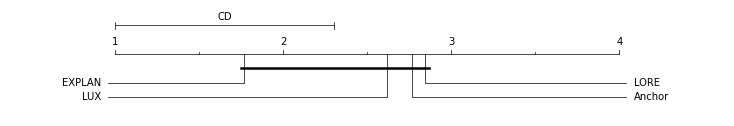

In [111]:
print(to_latex(aggregated, aggregated_std, index_name='dataset'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'],aggregated['Anchor'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
print(result[0])
print(result[1])

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')


nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

subjects.append('Fidelity')
lux.append(avranks[0])
explan.append(avranks[1])
lore.append(avranks[2])
anchor.append(avranks[3])

cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_fidelity.pdf')

In [112]:
result[1]

0.12339363732542653

## Simplicity

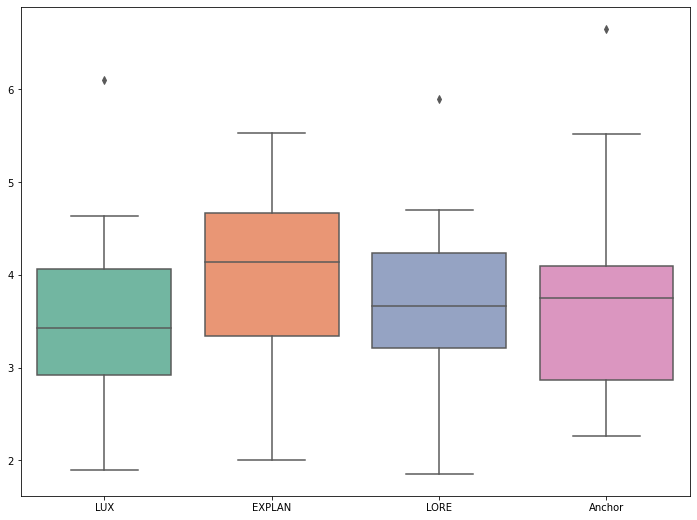

In [113]:

fig, ax = plt.subplots(figsize=(12,9))
aggregated = pd.read_csv(f'./results/{directory}/synthx100_rulelen.csv').dropna().groupby('dataset')[['shap_lux_elen','explan_elen','lore_elen','anchor_elen']].mean()
aggregated.columns=['LUX','EXPLAN','LORE','Anchor']
sns.boxplot(data=aggregated, ax=ax,palette='Set2', notch=False)
plt.savefig('./pix/simplicity-comp.pdf', format='pdf',bbox_inches='tight')
aggregated_std = pd.read_csv(f'./results/{directory}/synthx100_rulelen.csv').dropna().groupby('dataset')[['shap_lux_elen','explan_elen','lore_elen','anchor_elen']].std()
aggregated_std.columns=['LUX','EXPLAN','LORE','Anchor']


In [114]:
 to_latex(aggregated, aggregated_std, index_name='dataset')

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
dataset & LUX&EXPLAN&LORE&Anchor
\\ \hline \hline
cancer & 2.99 $\pm$ 0.90 & 4.78 $\pm$ 1.40 & 3.68 $\pm$ 1.35 & 2.63 $\pm$ 0.69\\ \hline
data_MagicTelescope & 3.57 $\pm$ 1.08 & 4.18 $\pm$ 1.40 & 3.66 $\pm$ 1.83 & 4.91 $\pm$ 4.05\\ \hline
data_bank-marketing & 2.92 $\pm$ 1.15 & 3.20 $\pm$ 1.24 & 2.73 $\pm$ 1.32 & 3.92 $\pm$ 2.56\\ \hline
data_california & 3.09 $\pm$ 0.85 & 3.41 $\pm$ 0.98 & 3.10 $\pm$ 0.86 & 3.75 $\pm$ 1.76\\ \hline
data_credit & 3.43 $\pm$ 1.37 & 4.24 $\pm$ 1.55 & 3.80 $\pm$ 1.87 & 4.09 $\pm$ 2.53\\ \hline
data_electricity & 2.14 $\pm$ 0.90 & 2.00 $\pm$ 0.58 & 1.86 $\pm$ 0.69 & 3.00 $\pm$ 1.29\\ \hline
data_eye_movements & 6.10 $\pm$ 1.60 & 5.53 $\pm$ 1.70 & 5.89 $\pm$ 2.35 & 2.26 $\pm$ 0.88\\ \hline
data_house_16H & 4.35 $\pm$ 1.22 & 4.67 $\pm$ 1.29 & 4.23 $\pm$ 1.71 & 3.30 $\pm$ 0.90\\ \hline
data_jannis & 4.63 $\pm$ 1.40 & 5.03 $\pm$ 1.49 & 4.70 $\pm$ 2.28 & 2.86 $\pm$ 0.94\\ \hline


In [115]:
result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'],aggregated['Anchor'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
print(result[0])
print(result[1])

4.292307692307702
0.23158109835825288


In [116]:
ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')

Reject null-hypothesis 2.86626555094018 < 4.292307692307702
Number of freedom degrees: 3 x 36


In [117]:

nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

,LUX,EXPLAN,LORE,Anchor
LUX,1.000000,0.197531,0.900000,0.773540
EXPLAN,0.197531,1.000000,0.427437,0.688274
LORE,0.900000,0.427437,1.000000,0.900000
Anchor,0.773540,0.688274,0.900000,1.000000


In [118]:
avranks=rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

subjects.append('Simplicity')
avinv = abs(avranks -max(avranks))+min(avranks)
lux.append(avinv[0])
explan.append(avinv[1])
lore.append(avinv[2])
anchor.append(avinv[3])

cd=1.300879920848843


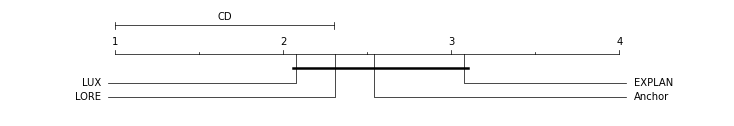

In [119]:
cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_simplicity.pdf')

## Counterfactuals

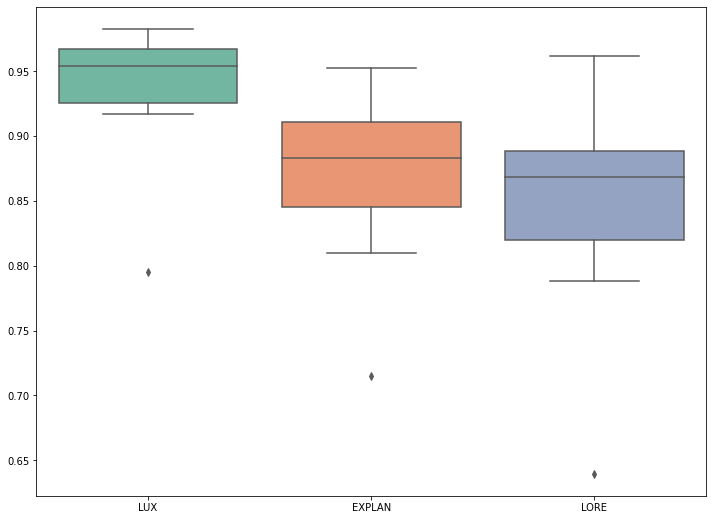

In [120]:

fig, ax = plt.subplots(figsize=(12,9))
aggregated = pd.read_csv(f'./results/{directory}/synthx100_scores.csv').fillna(0).groupby('dataset')[['f1_score_shap','f1_score_explan','f1_score_lore']].mean()
aggregated.columns=['LUX','EXPLAN','LORE']
sns.boxplot(data=aggregated, ax=ax,palette='Set2', notch=False)
plt.savefig('./pix/counterfactuals-comp.pdf', format='pdf',bbox_inches='tight')
aggregated_std = pd.read_csv(f'./results/{directory}/synthx100_scores.csv').fillna(0).groupby('dataset')[['f1_score_shap','f1_score_explan','f1_score_lore']].std()
aggregated_std.columns=['LUX','EXPLAN','LORE']


\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|}
\hline
dataset & LUX&EXPLAN&LORE
\\ \hline \hline
cancer & 0.97 $\pm$ 0.05 & 0.95 $\pm$ 0.13 & 0.96 $\pm$ 0.07\\ \hline
data_MagicTelescope & 0.93 $\pm$ 0.06 & 0.81 $\pm$ 0.15 & 0.82 $\pm$ 0.16\\ \hline
data_bank-marketing & 0.96 $\pm$ 0.03 & 0.91 $\pm$ 0.08 & 0.89 $\pm$ 0.10\\ \hline
data_california & 0.95 $\pm$ 0.02 & 0.88 $\pm$ 0.10 & 0.82 $\pm$ 0.12\\ \hline
data_credit & 0.96 $\pm$ 0.03 & 0.91 $\pm$ 0.07 & 0.89 $\pm$ 0.07\\ \hline
data_electricity & 0.98 $\pm$ 0.03 & 0.88 $\pm$ 0.15 & 0.87 $\pm$ 0.11\\ \hline
data_eye_movements & 0.80 $\pm$ 0.05 & 0.72 $\pm$ 0.08 & 0.64 $\pm$ 0.12\\ \hline
data_house_16H & 0.93 $\pm$ 0.05 & 0.89 $\pm$ 0.08 & 0.83 $\pm$ 0.13\\ \hline
data_jannis & 0.92 $\pm$ 0.06 & 0.82 $\pm$ 0.13 & 0.82 $\pm$ 0.12\\ \hline
data_kdd_ipums_la_97-small & 0.97 $\pm$ 0.03 & 0.95 $\pm$ 0.06 & 0.91 $\pm$ 0.11\\ \hline
data_phoneme & 0.95 $\pm$ 0.04 & 0.85 $\pm$ 0.11 & 0.87 $\pm$ 0.13\\ \hline
data_

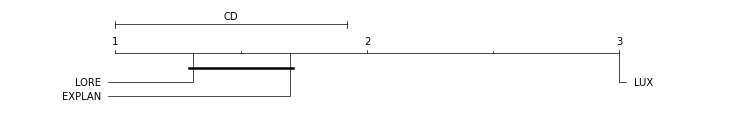

In [121]:
print(to_latex(aggregated, aggregated_std, index_name='dataset'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
result[0]
result[1]

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')


nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

subjects.append('Counterfactual Fidelity')
lux.append(avranks[0])
explan.append(avranks[1])
lore.append(avranks[2])
anchor.append(0)

cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_counterfactuals.pdf')

## Coverage

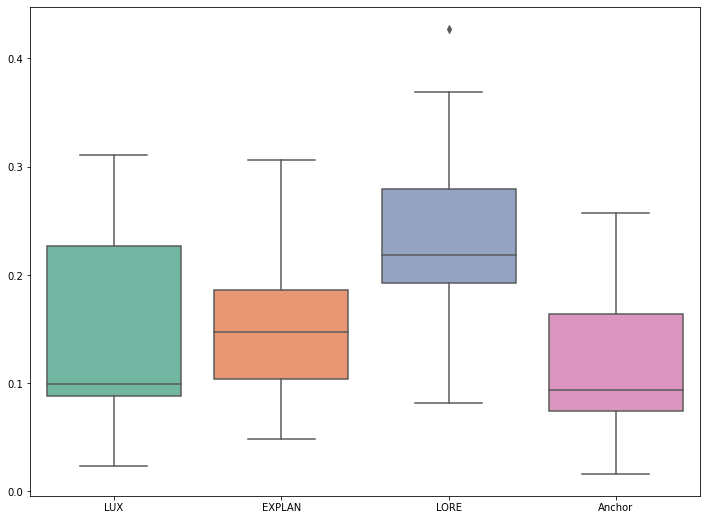

In [122]:

fig, ax = plt.subplots(figsize=(12,9))
aggregated = pd.read_csv(f'./results/{directory}/synthx100_rulecov.csv').fillna(0).groupby('dataset')[['cov_shap','cov_EXPLAN','cov_LORE', 'cov_anchor']].mean()
aggregated.columns=['LUX','EXPLAN','LORE', 'Anchor']
sns.boxplot(data=aggregated, ax=ax,palette='Set2', notch=False)
plt.savefig('./pix/coverage-comp.pdf', format='pdf',bbox_inches='tight')
aggregated_std = pd.read_csv(f'./results/{directory}/synthx100_rulecov.csv').fillna(0).groupby('dataset')[['cov_shap','cov_EXPLAN','cov_LORE', 'cov_anchor']].std()
aggregated_std.columns=['LUX','EXPLAN','LORE','Anchor']


\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
dataset & LUX&EXPLAN&LORE&Anchor
\\ \hline \hline
cancer & 0.31 $\pm$ 0.15 & 0.31 $\pm$ 0.20 & 0.43 $\pm$ 0.16 & 0.16 $\pm$ 0.08\\ \hline
data_MagicTelescope & 0.09 $\pm$ 0.09 & 0.10 $\pm$ 0.11 & 0.22 $\pm$ 0.18 & 0.08 $\pm$ 0.06\\ \hline
data_bank-marketing & 0.12 $\pm$ 0.10 & 0.19 $\pm$ 0.16 & 0.27 $\pm$ 0.15 & 0.13 $\pm$ 0.08\\ \hline
data_california & 0.10 $\pm$ 0.11 & 0.10 $\pm$ 0.12 & 0.15 $\pm$ 0.10 & 0.06 $\pm$ 0.05\\ \hline
data_credit & 0.19 $\pm$ 0.16 & 0.17 $\pm$ 0.15 & 0.28 $\pm$ 0.18 & 0.26 $\pm$ 0.18\\ \hline
data_electricity & 0.30 $\pm$ 0.27 & 0.18 $\pm$ 0.12 & 0.22 $\pm$ 0.10 & 0.09 $\pm$ 0.07\\ \hline
data_eye_movements & 0.02 $\pm$ 0.03 & 0.05 $\pm$ 0.06 & 0.08 $\pm$ 0.09 & 0.16 $\pm$ 0.11\\ \hline
data_house_16H & 0.09 $\pm$ 0.09 & 0.11 $\pm$ 0.10 & 0.19 $\pm$ 0.12 & 0.06 $\pm$ 0.06\\ \hline
data_jannis & 0.07 $\pm$ 0.06 & 0.08 $\pm$ 0.08 & 0.19 $\pm$ 0.14 & 0.09 $\pm$ 0.06\\ \hline


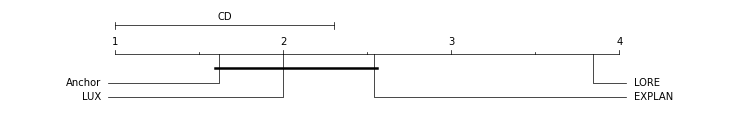

In [123]:
print(to_latex(aggregated, aggregated_std, index_name='dataset'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'],aggregated['Anchor'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
result[0]
result[1]

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')


nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

subjects.append('Coverage')
lux.append(avranks[0])
explan.append(avranks[1])
lore.append(avranks[2])
anchor.append(avranks[3])

cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_coverage.pdf')

## Stability

### instance-based

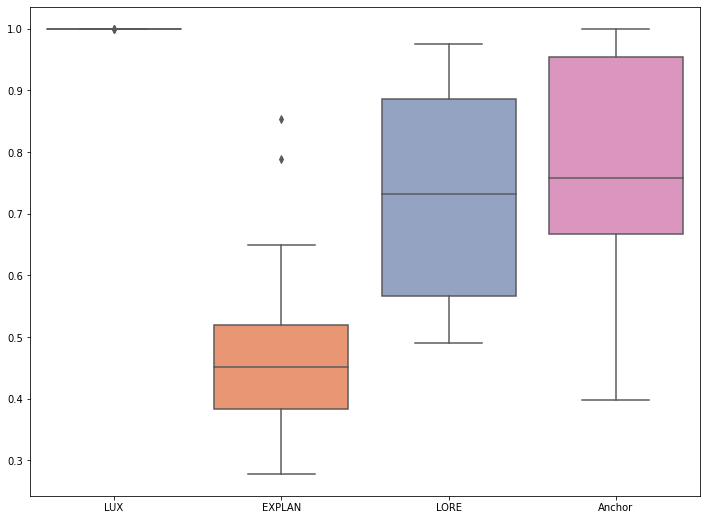

In [124]:
results_stab_data = pd.read_csv("./results/stability-multids4-20x10.csv").fillna(0)

instacne_stats_features = [f for f in results_stab_data if 'instance_mean' in f]
instance_consistency_data = results_stab_data[['num_and_cat']+instacne_stats_features].copy()

instance_consistency_data.columns=['Dataset','EXPLAN','LORE','Anchor','LUX']
forder = ['Dataset', 'LUX','EXPLAN','LORE','Anchor']
aggregated = instance_consistency_data[forder].set_index('Dataset')


fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=aggregated, ax=ax,palette='Set2', notch=False)
plt.savefig('./pix/consistency_instance-comp.pdf', format='pdf',bbox_inches='tight')
plt.show()


\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
Dataset & LUX&EXPLAN&LORE&Anchor
\\ \hline \hline
4 & 1.00 & 0.65 & 0.98 & 0.83\\ \hline
5 & 1.00 & 0.85 & 0.76 & 0.52\\ \hline
6 & 1.00 & 0.60 & 0.93 & 0.77\\ \hline
7 & 1.00 & 0.79 & 0.89 & 1.00\\ \hline
8 & 1.00 & 0.47 & 0.89 & 1.00\\ \hline
9 & 1.00 & 0.44 & 0.55 & 0.73\\ \hline
10 & 1.00 & 0.46 & 0.67 & 1.00\\ \hline
11 & 1.00 & 0.28 & 0.57 & 0.40\\ \hline
12 & 1.00 & 0.49 & 0.87 & 0.43\\ \hline
13 & 1.00 & 0.48 & 0.92 & 0.94\\ \hline
14 & 1.00 & 0.39 & 0.50 & 0.58\\ \hline
15 & 1.00 & 0.36 & 0.49 & 0.74\\ \hline
16 & 1.00 & 0.41 & 0.57 & 0.69\\ \hline
17 & 1.00 & 0.39 & 0.70 & 0.94\\ \hline
18 & 1.00 & 0.30 & 0.78 & 1.00\\ \hline
19 & 1.00 & 0.34 & 0.60 & 0.71\\ \hline
\end{tabularx}
\end{table}
None
Reject null-hypothesis 2.811543506332673 < 30.125
Number of freedom degrees: 3 x 45
cd=1.17259731446051


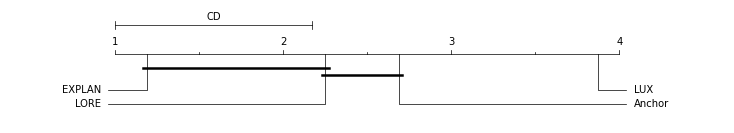

In [125]:
print(to_latex_nostd(aggregated, index_name='Dataset'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
result[0]
result[1]

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')


nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_consistency.pdf')

### Feature-based

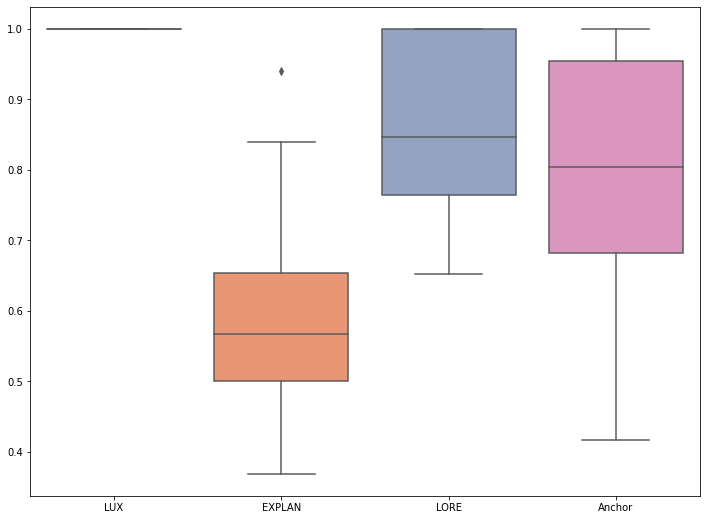

In [126]:
results_stab_data = pd.read_csv("./results/stability-multids4-20x10.csv").dropna()
instacne_stats_features = [f for f in results_stab_data if 'feature_mean' in f]
instance_consistency_data = results_stab_data[['num_and_cat']+instacne_stats_features].copy()

instance_consistency_data.columns=['Dataset','EXPLAN','LORE','Anchor','LUX']
forder = ['Dataset', 'LUX','EXPLAN','LORE','Anchor']
aggregated = instance_consistency_data[forder].set_index('Dataset')


fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=aggregated, ax=ax,palette='Set2', notch=False)
plt.savefig('./pix/consistency_feature-comp.pdf', format='pdf',bbox_inches='tight')
plt.show()


\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
Dataset & LUX&EXPLAN&LORE&Anchor
\\ \hline \hline
4 & 1.00 & 0.84 & 1.00 & 0.83\\ \hline
5 & 1.00 & 0.94 & 0.84 & 0.64\\ \hline
6 & 1.00 & 0.65 & 1.00 & 0.81\\ \hline
7 & 1.00 & 0.84 & 1.00 & 1.00\\ \hline
8 & 1.00 & 0.59 & 1.00 & 1.00\\ \hline
9 & 1.00 & 0.57 & 0.71 & 0.73\\ \hline
10 & 1.00 & 0.58 & 0.85 & 1.00\\ \hline
11 & 1.00 & 0.50 & 0.78 & 0.42\\ \hline
12 & 1.00 & 0.65 & 1.00 & 0.48\\ \hline
13 & 1.00 & 0.56 & 1.00 & 0.94\\ \hline
14 & 1.00 & 0.52 & 0.66 & 0.58\\ \hline
15 & 1.00 & 0.47 & 0.66 & 0.74\\ \hline
16 & 1.00 & 0.50 & 0.65 & 0.69\\ \hline
17 & 1.00 & 0.50 & 0.79 & 0.94\\ \hline
18 & 1.00 & 0.37 & 0.93 & 1.00\\ \hline
19 & 1.00 & 0.49 & 0.79 & 0.80\\ \hline
\end{tabularx}
\end{table}
None
Reject null-hypothesis 2.811543506332673 < 30.0
Number of freedom degrees: 3 x 45
cd=1.17259731446051


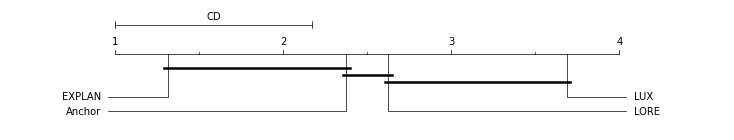

In [127]:
print(to_latex_nostd(aggregated, index_name='Dataset'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'],aggregated['Anchor'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
result[0]
result[1]

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')


nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

subjects.append('Consistency')
lux.append(avranks[0])
explan.append(avranks[1])
lore.append(avranks[2])
anchor.append(avranks[3])

cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_consistency.pdf')

## Counterfactual representativeness (Phantom branches)

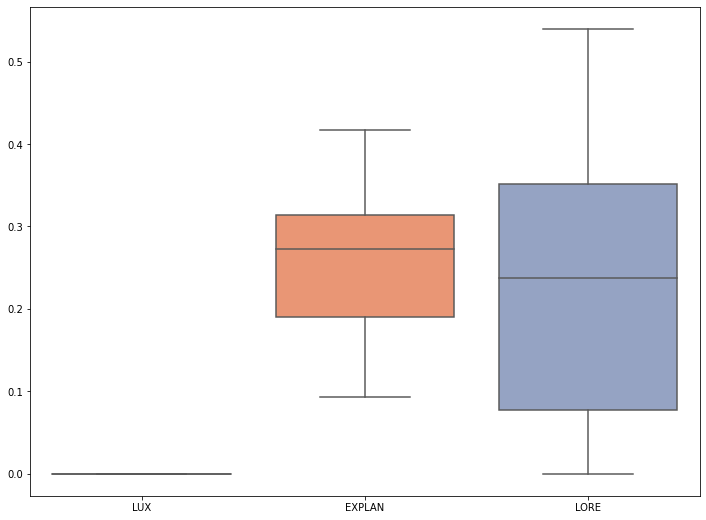

In [128]:

fig, ax = plt.subplots(figsize=(12,9))
aggregated = pd.read_csv('./results/phantoms-shap.csv').dropna().groupby('dimensionality')[['phantom_ratio_lux','phantom_ratio_explan', 'phantom_ratio_lore']].mean()
aggregated.columns=['LUX','EXPLAN','LORE']
sns.boxplot(data=aggregated, ax=ax,palette='Set2', notch=False)
plt.savefig('./pix/representativeness-comp.pdf', format='pdf',bbox_inches='tight')
aggregated_std = pd.read_csv('./results/phantoms-shap.csv').dropna().groupby('dimensionality')[[ 'phantom_ratio_lux','phantom_ratio_explan', 'phantom_ratio_lore']].std()
aggregated_std.columns=['LUX','EXPLAN','LORE']


\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|}
\hline
Dataset size & LUX&EXPLAN&LORE
\\ \hline \hline
2 & 0.00 & 0.42 & 0.00\\ \hline
3 & 0.00 & 0.29 & 0.00\\ \hline
4 & 0.00 & 0.20 & 0.45\\ \hline
5 & 0.00 & 0.23 & 0.00\\ \hline
6 & 0.00 & 0.15 & 0.07\\ \hline
7 & 0.00 & 0.36 & 0.40\\ \hline
8 & 0.00 & 0.09 & 0.11\\ \hline
9 & 0.00 & 0.27 & 0.25\\ \hline
10 & 0.00 & 0.19 & 0.33\\ \hline
11 & 0.00 & 0.28 & 0.22\\ \hline
12 & 0.00 & 0.40 & 0.29\\ \hline
13 & 0.00 & 0.32 & 0.22\\ \hline
14 & 0.00 & 0.29 & 0.54\\ \hline
15 & 0.00 & 0.19 & 0.36\\ \hline
\end{tabularx}
\end{table}
None
Reject null-hypothesis 3.3690163594954443 < 18.150943396226403
Number of freedom degrees: 2 x 26
cd=0.8858357133561987


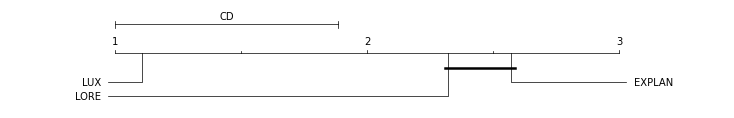

In [129]:
print(to_latex_nostd(aggregated, index_name='Dataset size'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
result[0]
result[1]

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')


nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

avinv = abs(avranks -max(avranks))+min(avranks)
subjects.append('Representativeness')
lux.append(avinv[0])
explan.append(avinv[1])
lore.append(avinv[2])
anchor.append(0)

cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_representativeness.pdf')

## Shap-consistency

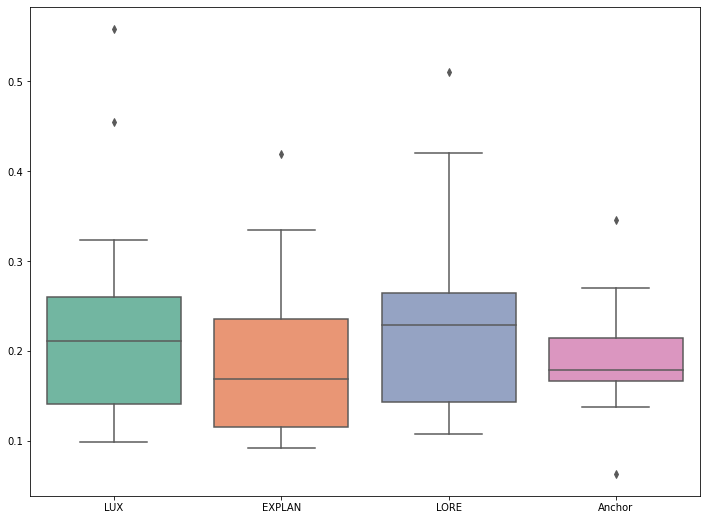

In [130]:

fig, ax = plt.subplots(figsize=(12,9))
aggregated = pd.read_csv(f'./results/{directory}/synthx100_importance_gain.csv').fillna(0).groupby('dataset')[['importance_gain_shap','importance_gain_explan','importance_gain_lore','importance_gain_anchor']].mean()
aggregated.columns=['LUX','EXPLAN','LORE', 'Anchor']
sns.boxplot(data=aggregated, ax=ax,palette='Set2', notch=False)
plt.savefig('./pix/shapconsistency-comp.pdf', format='pdf',bbox_inches='tight')
aggregated_std = pd.read_csv(f'./results/{directory}/synthx100_importance_gain.csv').fillna(0).groupby('dataset')[['importance_gain_shap','importance_gain_explan','importance_gain_lore','importance_gain_anchor']].std()
aggregated_std.columns=['LUX','EXPLAN','LORE','Anchor']


\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
Dataset size & LUX&EXPLAN&LORE&Anchor
\\ \hline \hline
cancer & 0.10 & 0.10 & 0.12 & 0.06\\ \hline
data_MagicTelescope & 0.24 & 0.16 & 0.24 & 0.18\\ \hline
data_bank-marketing & 0.32 & 0.28 & 0.36 & 0.27\\ \hline
data_california & 0.26 & 0.23 & 0.26 & 0.22\\ \hline
data_credit & 0.21 & 0.17 & 0.23 & 0.21\\ \hline
data_electricity & 0.45 & 0.42 & 0.51 & 0.35\\ \hline
data_eye_movements & 0.11 & 0.10 & 0.11 & 0.17\\ \hline
data_house_16H & 0.14 & 0.11 & 0.14 & 0.14\\ \hline
data_jannis & 0.13 & 0.09 & 0.12 & 0.14\\ \hline
data_kdd_ipums_la_97-small & 0.21 & 0.17 & 0.20 & 0.20\\ \hline
data_phoneme & 0.23 & 0.24 & 0.26 & 0.17\\ \hline
data_pol & 0.56 & 0.34 & 0.42 & 0.18\\ \hline
data_wine & 0.17 & 0.15 & 0.18 & 0.17\\ \hline
\end{tabularx}
\end{table}
None
Reject null-hypothesis 2.86626555094018 < 18.0
Number of freedom degrees: 3 x 36
cd=1.300879920848843


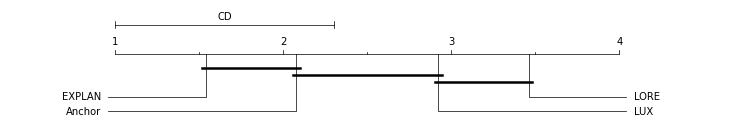

In [131]:
print(to_latex_nostd(aggregated, index_name='Dataset size'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
result[0]
result[1]

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')


nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

subjects.append('SHAP Consistency')
lux.append(avranks[0])
explan.append(avranks[1])
lore.append(avranks[2])
anchor.append(avranks[3])

cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_shapconsistency.pdf')

## Stability real data

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
Dataset size & LUX&EXPLAN&LORE&Anchor
\\ \hline \hline
cancer & 0.33 & 0.31 & 0.32 & 0.15\\ \hline
data_MagicTelescope & 0.53 & 0.41 & 0.40 & 0.38\\ \hline
data_bank-marketing & 0.50 & 0.46 & 0.50 & 0.42\\ \hline
data_california & 0.64 & 0.58 & 0.64 & 0.48\\ \hline
data_credit & 0.47 & 0.42 & 0.40 & 0.45\\ \hline
data_eye_movements & 0.49 & 0.34 & 0.30 & 0.33\\ \hline
data_house_16H & 0.43 & 0.39 & 0.38 & 0.31\\ \hline
data_jannis & 0.35 & 0.29 & 0.29 & 0.32\\ \hline
data_kdd_ipums_la_97-small & 0.26 & 0.45 & 0.41 & 0.29\\ \hline
data_phoneme & 0.65 & 0.54 & 0.55 & 0.66\\ \hline
data_pol & 0.35 & 0.45 & 0.35 & 0.32\\ \hline
data_wine & 0.37 & 0.35 & 0.36 & 0.33\\ \hline
\end{tabularx}
\end{table}
None
Reject null-hypothesis 2.89156351734836 < 8.166666666666657
Number of freedom degrees: 3 x 33
cd=1.3539987503096154


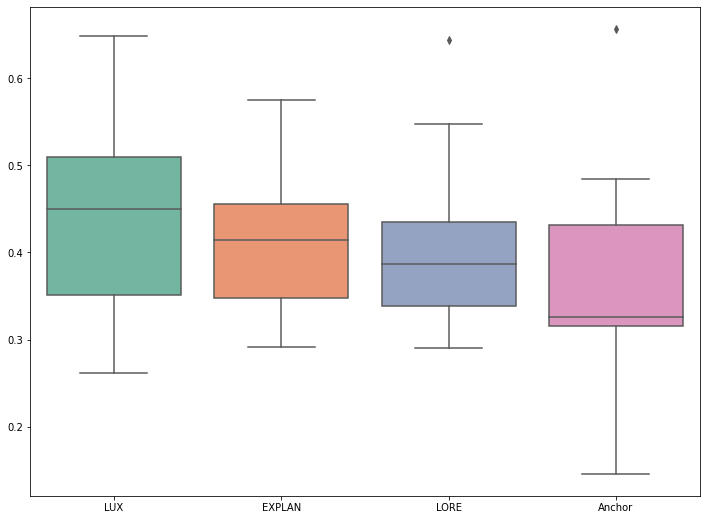

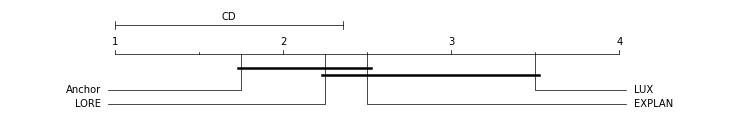

In [132]:

fig, ax = plt.subplots(figsize=(12,9))
aggregated = pd.read_csv(f'./results/{directory}/synthx100_stability.csv').fillna(0).groupby('dataset')[['feature_mean_rule_lux_shap','feature_mean_rule_EXPLAN','feature_mean_rule_LORE','feature_mean_rule_Anchor']].mean()
aggregated.columns=['LUX','EXPLAN','LORE', 'Anchor']
sns.boxplot(data=aggregated, ax=ax,palette='Set2', notch=False)
plt.savefig('./pix/stability_real-comp.pdf', format='pdf',bbox_inches='tight')
aggregated_std = pd.read_csv(f'./results/{directory}/synthx100_stability.csv').fillna(0).groupby('dataset')[['feature_mean_rule_lux_shap','feature_mean_rule_EXPLAN','feature_mean_rule_LORE','feature_mean_rule_Anchor']].std()
aggregated_std.columns=['LUX','EXPLAN','LORE','Anchor']


print(to_latex_nostd(aggregated, index_name='Dataset size'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
result[0]
result[1]

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')


nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

subjects.append('Stability')
lux.append(avranks[0])
explan.append(avranks[1])
lore.append(avranks[2])
anchor.append(avranks[3])

cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_stability_real.pdf')





## Spiderplot

In [133]:
def area(method, angle):
    a = 0
    for i in range(0,len(method)-1):
        a += 0.5*method[i]*method[i+1]*np.sin(angle)
    return a

In [134]:
angles=np.linspace(0,2*np.pi,len(subjects), endpoint=False)

In [135]:
angles=np.concatenate((angles,[angles[0]]))
subjects.append(subjects[0])
lux.append(lux[0])
lore.append(lore[0])
explan.append(explan[0])
anchor.append(anchor[0])

In [136]:
objects = ['Lux','Lore','Explan','Anchor']
palette = dict(zip(objects,sns.color_palette('Set2',len(objects))))

In [137]:
angle = 2*np.pi/(len(subjects)-2)
alux = area(lux, angle)
alore = area(lore, angle)
aexplan = area(explan, angle)
aanchor = area(anchor, angle)

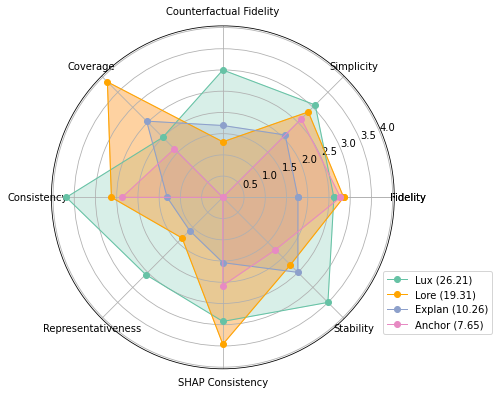

In [138]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111, polar=True)
#Alice Plot
ax.plot(angles,lux, 'o-', color=palette['Lux'], linewidth=1, label=f'Lux ({alux:.2f})')
ax.fill(angles, lux, alpha=0.25, color=palette['Lux'])
#Bob Plot
ax.plot(angles,lore, 'o-', color='orange', linewidth=1, label=f'Lore ({alore:.2f})')
ax.fill(angles, lore, alpha=0.25, color=palette['Lore'])

ax.plot(angles,explan, 'o-', color=palette['Explan'], linewidth=1, label=f'Explan ({aexplan:.2f})')
ax.fill(angles, explan, alpha=0.25, color=palette['Explan'])

ax.plot(angles,anchor, 'o-', color=palette['Anchor'], linewidth=1, label=f'Anchor ({aanchor:.2f})')
ax.fill(angles, anchor, alpha=0.25, color=palette['Anchor'])


ax.fill(angles, lore, alpha=0.25, color='orange')
ax.set_thetagrids(angles * 180/np.pi, subjects)
plt.grid(True)
plt.tight_layout()
plt.legend(loc='best', bbox_to_anchor=(0.9, 0.0, 0.4, 0.3))
plt.savefig('./pix/spiderplot.pdf', format='pdf',bbox_inches='tight')
plt.show()

In [ ]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111, polar=True)
#Alice Plot
ax.plot(angles,lux, 'o-', color=palette['Lux'], linewidth=1, label=f'Lux ({alux:.2f})')
ax.fill(angles, lux, alpha=0.25, color=palette['Lux'])
#Bob Plot
ax.plot(angles,lore, 'o-', color='orange', linewidth=1, label=f'Lore ({alore:.2f})')
ax.fill(angles, lore, alpha=0.25, color=palette['Lore'])

ax.plot(angles,explan, 'o-', color=palette['Explan'], linewidth=1, label=f'Explan ({aexplan:.2f})')
ax.fill(angles, explan, alpha=0.25, color=palette['Explan'])

ax.plot(angles,anchor, 'o-', color=palette['Anchor'], linewidth=1, label=f'Anchor ({aanchor:.2f})')
ax.fill(angles, anchor, alpha=0.25, color=palette['Anchor'])


ax.fill(angles, lore, alpha=0.25, color='orange')
ax.set_thetagrids(angles * 180/np.pi, subjects)
plt.grid(True)
plt.tight_layout()
plt.legend(loc='best', bbox_to_anchor=(0.9, 0.0, 0.4, 0.3))
plt.savefig('./pix/spiderplot.svg', format='svg',bbox_inches='tight')
plt.show()

In [ ]:
results_hits =  pd.read_csv(f'./results/{directory}/synthx100_hits.csv').dropna()#fillna(0)#.groupby('dataset')[['feature_mean_rule_lux_shap','feature_mean_rule_EXPLAN','feature_mean_rule_LORE','feature_mean_rule_Anchor']
#results_hits.to_csv(data_prefix+"synthx100_hits.csv",index=False)
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_hits.groupby('dataset').mean(),notch=True,ax=ax,showmeans=True)
plt.xticks(rotation=90)